In [2]:
from gensim.models import KeyedVectors
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import requests
from sklearn.manifold import TSNE
import matplotlib.patches as patches
import re
import pickle
import google_conf
import matplotlib.gridspec as gridspec


In [5]:
# point out to your google service account and a google sheet URL to which you wish to send your data
theos_data = google_conf.setup(sheet_url="https://docs.google.com/spreadsheets/d/19gfECdrg5rDiU2PhNYL1nKifeKzemCfYtYrAHQX5vXE/edit?usp=sharing", service_account_path="../../../ServiceAccountsKey.json")

In [7]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [8]:
# global parameters for plots
#plt.style.use("fast")
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

In [9]:
#!pip install --upgrade git+https://github.com/kbatsuren/wiktra/

from wiktra.Wiktra import Transliterator
tr = Transliterator()

In [10]:
greek_word = "ἱδρύω"
transli = tr.tr(greek_word, lang='grc', sc='Grek', to_sc='Latn', explicit=True)
def transliterator(term):
    transli = tr.tr(strip_accents(term), lang='grc', sc='Grek', to_sc='Latn', explicit=True)
    transli = transli.replace("Kh", "Ch")
    return transli

In [11]:
from greek_accentuation.characters import strip_accents
strip_accents("ἱδρύω")

'ἱδρυω'

In [12]:
transliterator("ἱδρύω")

'hidruō'

In [13]:
with open("../data/subcorpora_ids_dict.pickle", "rb") as f:
    subcorpora_ids_dict= pickle.load(f)

In [14]:
with open("../data/shared_vocabulary.pickle", "rb") as f:
    shared_vocabulary = pickle.load(f)

In [15]:
subcorpora = list(subcorpora_ids_dict.keys())

religion_final = ["θεός", "Ζεύς", "εὐσεβής", 'ἱερός']
morality_final = ["ἀγαθός", "ἀρετή", "δίκαιος", "τιμή"]

In [19]:
#curl -L -o data/large_data/vectors_sample1m_dict.pickle "https://zenodo.org/records/10685268/files/vectors_sample1m_dict.pickle?download=1"

with open("../data/large_data/vectors_sample1m_dict.pickle", "rb") as f:
    vectors_sample1m_dict = pickle.load(f)

In [20]:
vectors_sample1m_dict["pagan_archaic"].most_similar("θεός", topn=10)

[('Ζεύς', 0.5235968232154846),
 ('ἀθάνατος', 0.45142000913619995),
 ('Κρονίδης', 0.42033568024635315),
 ('μάκαρ', 0.40976470708847046),
 ('ἄλλος', 0.4085693359375),
 ('ἀγήραος', 0.3908531367778778),
 ('νόος', 0.3755967319011688),
 ('Ὀλύμπιος', 0.37464356422424316),
 ('τιμή', 0.3715208172798157),
 ('βροτός', 0.3592821955680847)]

In [21]:
vectors_sample1m_dict["christian_roman_peak"].most_similar("θεός", topn=10)

[('πατήρ', 0.6966220736503601),
 ('πᾶς', 0.5828402042388916),
 ('μονογενής', 0.5566739439964294),
 ('κύριος', 0.5352228879928589),
 ('ἄνθρωπος', 0.5106222033500671),
 ('αὐτός', 0.5007627606391907),
 ('Χριστός', 0.4946483373641968),
 ('δημιουργός', 0.49166369438171387),
 ('παντοκράτωρ', 0.4795956313610077),
 ('υἱός', 0.4744877219200134)]

In [22]:
pagan_archaic_theos = [transliterator(tup[0]) + " ({})".format(str(np.round(tup[1], 3))) for tup in vectors_sample1m_dict["pagan_archaic"].most_similar("θεός")]
christian_roman_peak_theos = [transliterator(tup[0]) + " ({})".format(str(np.round(tup[1], 3))) for tup in vectors_sample1m_dict["christian_roman_peak"].most_similar("θεός")]

In [23]:
theos_nns = pd.DataFrame({"archaic 8-6BCE θεός NNs" : pagan_archaic_theos, "christian 1-2CE θεός NNs" : christian_roman_peak_theos})
theos_nns

,archaic 8-6BCE θεός NNs,christian 1-2CE θεός NNs
0,Zeus (0.524),patēr (0.697)
1,athanatos (0.451),pas (0.583)
2,Kronidēs (0.42),monogenēs (0.557)
3,makar (0.41),kurios (0.535)
4,allos (0.409),anthrōpos (0.511)
5,agēraos (0.391),autos (0.501)
6,noos (0.376),Christos (0.495)
7,Olumpios (0.375),dēmiourgos (0.492)
8,timē (0.372),pantokratōr (0.48)
9,brotos (0.359),huios (0.474)


In [25]:
#google_conf.set_with_dataframe(theos_data.add_worksheet("theos_nns_transl", 1,1), theos_nns)
theos_nns.to_csv("../data/theos_nns_transl.csv", index=False)


In [26]:
n = 20
dfs = {}
for sub in subcorpora:
    sub_data = {}
    for key in religion_final + morality_final:
        neighbors_tups = vectors_sample1m_dict[sub].most_similar(key, topn=n)
        tups_formatted = [tup[0] + " ({})".format(str(np.round(tup[1], 2))) for tup in neighbors_tups]
        sub_data[sub + " " + key] =  tups_formatted
    sub_data_df = pd.DataFrame(sub_data)
    dfs[sub] = sub_data_df


In [27]:
dfs["pagan_archaic"]

,pagan_archaic θεός,pagan_archaic Ζεύς,pagan_archaic εὐσεβής,pagan_archaic ἱερός,pagan_archaic ἀγαθός,pagan_archaic ἀρετή,pagan_archaic δίκαιος,pagan_archaic τιμή
0,Ζεύς (0.52),θεός (0.52),ἐπαγγελία (0.56),ἱερόν (0.41),διοτρεφής (0.38),λατρεία (0.4),Προμηθεύς (0.41),θεός (0.37)
1,ἀθάνατος (0.45),εὔκομος (0.44),ἔδεσμα (0.45),ἕδρα (0.33),Ἀφροδίσιος (0.35),ἆθλον (0.39),τοσόσδε (0.4),θνητός (0.37)
2,Κρονίδης (0.42),Ὀλύμπιος (0.43),ἀνώμαλος (0.44),ἱλάσκομαι (0.31),Πέρσης (0.35),μονή (0.38),πονηρός (0.39),γονή (0.35)
3,μάκαρ (0.41),μάκαρ (0.42),ἐγκρατής (0.44),Αἰθίοψ (0.29),διάνοια (0.34),πάλη (0.38),ἁμαρτία (0.39),τίω (0.35)
4,ἄλλος (0.41),κελαινεφής (0.37),σύμβουλος (0.43),ἑκατόμβη (0.28),Διοτρεφής (0.33),ὄλβος (0.36),τοὔ (0.39),ὄλβος (0.34)
5,ἀγήραος (0.39),κύδιστος (0.36),Μῆδος (0.42),ὑμέτερος (0.28),μῦθος (0.32),ἀμήχανος (0.33),καταγιγνώσκω (0.37),ἀθάνατος (0.34)
6,νόος (0.38),Κρονίδης (0.36),πιθανός (0.41),ἀγοράομαι (0.28),δάω (0.3),διάδοχος (0.32),ὑβρίζω (0.37),κῦδος (0.33)
7,Ὀλύμπιος (0.37),Ἀπόλλων (0.34),διαλογισμός (0.41),αὐλή (0.27),νόμισμα (0.3),ἔσσομαι (0.31),διαίρεσις (0.37),δίδωμι (0.33)
8,τιμή (0.37),Οὐρανίωνες (0.34),τρόπαιον (0.41),κλυτός (0.27),ψεύδω (0.3),χάρις (0.3),εὔκαιρος (0.36),ἀνάσσω (0.32)
9,βροτός (0.36),ἀθάνατος (0.34),ἐπιγινώσκω (0.41),ἀέναος (0.27),ἐπαινέω (0.29),ἐμφύω (0.29),ἐρεθίζω (0.36),Πηλεύς (0.31)


In [52]:
dfs["pagan_classical"]

,pagan_classical θεός,pagan_classical Ζεύς,pagan_classical εὐσεβής,pagan_classical ἱερός,pagan_classical ἀγαθός,pagan_classical ἀρετή,pagan_classical δίκαιος,pagan_classical τιμή
0,δαίμων (0.62),Κρόνος (0.65),μάκαρ (0.63),ἱερόν (0.7),σπουδαῖος (0.63),σωφροσύνη (0.71),εὔνοια (0.59),γέρας (0.64)
1,Ἀπόλλων (0.5),Ἥρα (0.64),σέβω (0.62),τέμενος (0.69),ὠφέλιμος (0.6),εὐδαιμονία (0.64),ἄδικος (0.56),τιμάω (0.6)
2,θυσία (0.5),Ἀπόλλων (0.63),δυσσέβεια (0.61),βωμός (0.68),ἀρετή (0.56),ἀνδρεία (0.6),ἀδικέω (0.54),δωρεά (0.6)
3,δαιμόνιον (0.49),θεά (0.58),τίω (0.61),θύω (0.59),εὐδαιμονία (0.54),φρόνησις (0.58),ἐπιεικής (0.54),εὐεργεσία (0.57)
4,εὐσεβής (0.49),Λητώ (0.58),ὅσιος (0.61),ἕδος (0.58),αἱρετός (0.54),δικαιοσύνη (0.56),λυσιτελέω (0.53),χάρις (0.55)
5,εὐχή (0.48),Ῥέα (0.58),ἀσεβέω (0.6),θυσία (0.57),ἐπιεικής (0.54),ἀγαθός (0.56),δημοτικός (0.52),ἀξία (0.54)
6,ὅσιος (0.45),γαμβρός (0.57),Ὀλύμπιος (0.6),ἱερεύς (0.57),χρηστός (0.53),κτῆσις (0.56),δικάζω (0.52),κτῆσις (0.54)
7,θέμις (0.45),Ἀθήνη (0.57),κικλήσκω (0.59),Ἀθήνη (0.55),εὐδαιμονέω (0.52),κακία (0.56),προαιρέω (0.51),δόσις (0.53)
8,θνητός (0.44),φέρτατος (0.57),ἐχθαίρω (0.59),ἅγιος (0.55),σώφρων (0.51),εὐγένεια (0.55),ὅσιος (0.51),πλοῦτος (0.52)
9,ἀθάνατος (0.44),Κρονίδης (0.57),στυγέω (0.58),ἑορτή (0.54),πολιτεύω (0.51),πλοῦτος (0.55),ἀπολογία (0.51),εὐγένεια (0.5)


In [53]:
morality_extension = ["δικαιοσύνη", "δικαιόω", "ἀδικέω", "ἄδικος", "σωφροσύνη", "φίλος", "ἁμαρτία", "πονηρός", "κακός", "τιμάω", "εὐεργετέω", "εὐεργεσία" "εὐεργέτης", "σπουδαῖος", "ἐπαινετός","βέλτιστος", "βελτίων", "μεγαλοψυχία", "μεγαλόψυχος", "τιμάω", "εὔνοια", "καλός", "ἀλήθεια"]
religion_extension = ["εὐχή", "θεά", "θεῖος", "εὐσέβεια", "εὐσεβέω", "εὐλογέω", "εὐλογητός", "θεοφιλής", "ἀσεβέω", "ἀσεβής", "εὐσέβεια", "θύω", "δαίμων", "δαιμόνιον", "τελετή", "θεῖος", "ἱερόν", "εὔχομαι", "ναός", "καθιερόω", "ἱερή"]

In [54]:
print(", ".join(morality_extension))

δικαιοσύνη, δικαιόω, ἀδικέω, ἄδικος, σωφροσύνη, φίλος, ἁμαρτία, πονηρός, κακός, τιμάω, εὐεργετέω, εὐεργεσίαεὐεργέτης, σπουδαῖος, ἐπαινετός, βέλτιστος, βελτίων, μεγαλοψυχία, μεγαλόψυχος, τιμάω, εὔνοια, καλός, ἀλήθεια


In [55]:
print(", ".join(religion_extension))


εὐχή, θεά, θεῖος, εὐσέβεια, εὐσεβέω, εὐλογέω, εὐλογητός, θεοφιλής, ἀσεβέω, ἀσεβής, εὐσέβεια, θύω, δαίμων, δαιμόνιον, τελετή, θεῖος, ἱερόν, εὔχομαι, ναός, καθιερόω, ἱερή


In [56]:
sim_pairs = []
def get_sim_pairs(sub):
    sim_pairs = []
    for worda in religion_final:
        worda_mostvals = [tup[1] for tup in vectors_sample1m_dict[sub].most_similar(worda, topn=10)]
        for wordb in morality_final:
            wordb_mostvals = [tup[1] for tup in vectors_sample1m_dict[sub].most_similar(wordb, topn=10)]
            mostmean = np.mean(worda_mostvals + wordb_mostvals)
            pair_sim_raw = vectors_sample1m_dict[sub].similarity(worda, wordb)
            pair_sim_weighted = pair_sim_raw / mostmean
            if pair_sim_weighted <= 0:
                pair_sim_weighted = 0
            sim_pairs.append((worda, wordb, pair_sim_weighted))
    return sim_pairs

In [57]:
sim_pairs = get_sim_pairs("pagan_archaic")
sim_pairs

[('θεός', 'ἀγαθός', 0),
 ('θεός', 'ἀρετή', 0.14879682347778364),
 ('θεός', 'δίκαιος', 0.17151806814497414),
 ('θεός', 'τιμή', 0.9937303497869696),
 ('Ζεύς', 'ἀγαθός', 0),
 ('Ζεύς', 'ἀρετή', 0.09573920337249911),
 ('Ζεύς', 'δίκαιος', 0.0785653570505348),
 ('Ζεύς', 'τιμή', 0.7793069351212233),
 ('εὐσεβής', 'ἀγαθός', 0),
 ('εὐσεβής', 'ἀρετή', 0.24400797698931304),
 ('εὐσεβής', 'δίκαιος', 0.44696818634990854),
 ('εὐσεβής', 'τιμή', 0.45291866368126005),
 ('ἱερός', 'ἀγαθός', 0),
 ('ἱερός', 'ἀρετή', 0),
 ('ἱερός', 'δίκαιος', 0.449511745006203),
 ('ἱερός', 'τιμή', 0.3636238784329218)]

In [58]:
sim_pairs = get_sim_pairs("christian_roman_late")
sim_pairs

[('θεός', 'ἀγαθός', 0.688104190841564),
 ('θεός', 'ἀρετή', 0.27997295508649017),
 ('θεός', 'δίκαιος', 0.4904857362989734),
 ('θεός', 'τιμή', 0.3311256928690957),
 ('Ζεύς', 'ἀγαθός', 0),
 ('Ζεύς', 'ἀρετή', 0),
 ('Ζεύς', 'δίκαιος', 0),
 ('Ζεύς', 'τιμή', 0.0884581002604174),
 ('εὐσεβής', 'ἀγαθός', 0.6321474644249847),
 ('εὐσεβής', 'ἀρετή', 0.6614013837336445),
 ('εὐσεβής', 'δίκαιος', 0.660283428753941),
 ('εὐσεβής', 'τιμή', 0.18965676141223992),
 ('ἱερός', 'ἀγαθός', 0),
 ('ἱερός', 'ἀρετή', 0),
 ('ἱερός', 'δίκαιος', 0),
 ('ἱερός', 'τιμή', 0.12239214678789237)]

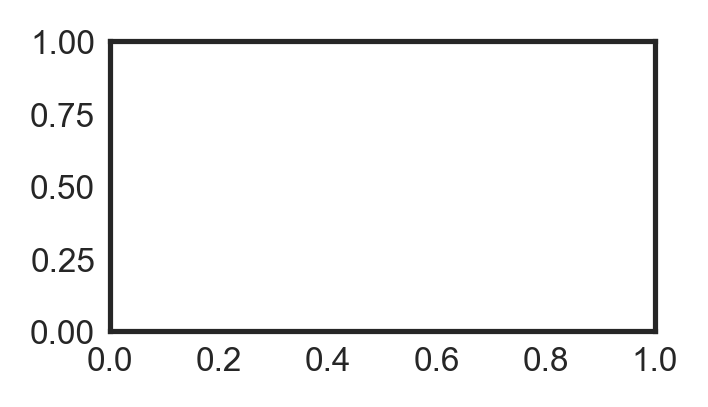

In [59]:
fig, ax = plt.subplots(figsize=(2.4, 1.4), tight_layout=True, dpi=300)

In [60]:
subcorpora_ordered = ['pagan_archaic',
                      'pagan_classical',
                      'pagan_hellenistic',
                      'jewish',
                      'pagan_roman_peak',
                      'pagan_roman_late',
                      'christian_roman_peak',
                      'christian_roman_late']

In [61]:
coords = []
for n_lower in range(4):
    for n_upper in range(4):
        xs, ys = [n_lower, n_upper], [0,1]
        coords.append((xs, ys))
color_dict = {
    "θεός" : "tab:blue",
    "Ζεύς" : "tab:orange",
    "εὐσεβής" : "tab:green",
    "ἱερός" : "tab:red",
}

In [97]:
def plot_binet(sub, ax, width_coef=10, title=None):
    sim_pairs = get_sim_pairs(sub)
    for n, word in enumerate(religion_final):
        ax.text(x=n, y=0, s=f"$\it{{{transliterator(word)}}}$", fontsize=6, color=color_dict[word], horizontalalignment='center', verticalalignment='center')
        circle = patches.Circle(xy=(n, 0), radius=0.36, facecolor="white", linewidth=0.5, edgecolor="black", zorder=2)
        ax.add_patch(circle)
    for n, word in enumerate(morality_final):
        ax.text(x=n, y=1, s=f"$\it{{{transliterator(word)}}}$", fontsize=6, horizontalalignment='center', verticalalignment='center')
        circle = patches.Circle(xy=(n, 1), radius=0.36, facecolor="white", linewidth=0.5, edgecolor="black", zorder=2)
        ax.add_patch(circle)
    for tup, coord in zip(sim_pairs, coords):
        if tup[2] > 0:
            ax.plot(coord[0], coord[1], linewidth=tup[2]*width_coef, alpha=0.7, color=color_dict[tup[0]], zorder=1)
    ax.set_xlim(-0.38,3.38)
    ax.set_ylim(-0.4, 1.4)
    ax.axis(False)
    if title != None:
        ax.set_title(title, fontsize=8)
    else:
        ax.set_title(sub, fontsize=8)
    return ax

In [100]:
subcorpora_labels = ["Pag. Archaic (8-6BCE)", "Pag. Classical (5-4BCE)", "Pag. Hellenistic (3-1BCE)",
                     "Pag. Roman (1-2CE)", "Pag. Roman (3-6CE)", "Christian (1-2CE)", "Christian (3-6CE)", "Jewish"]

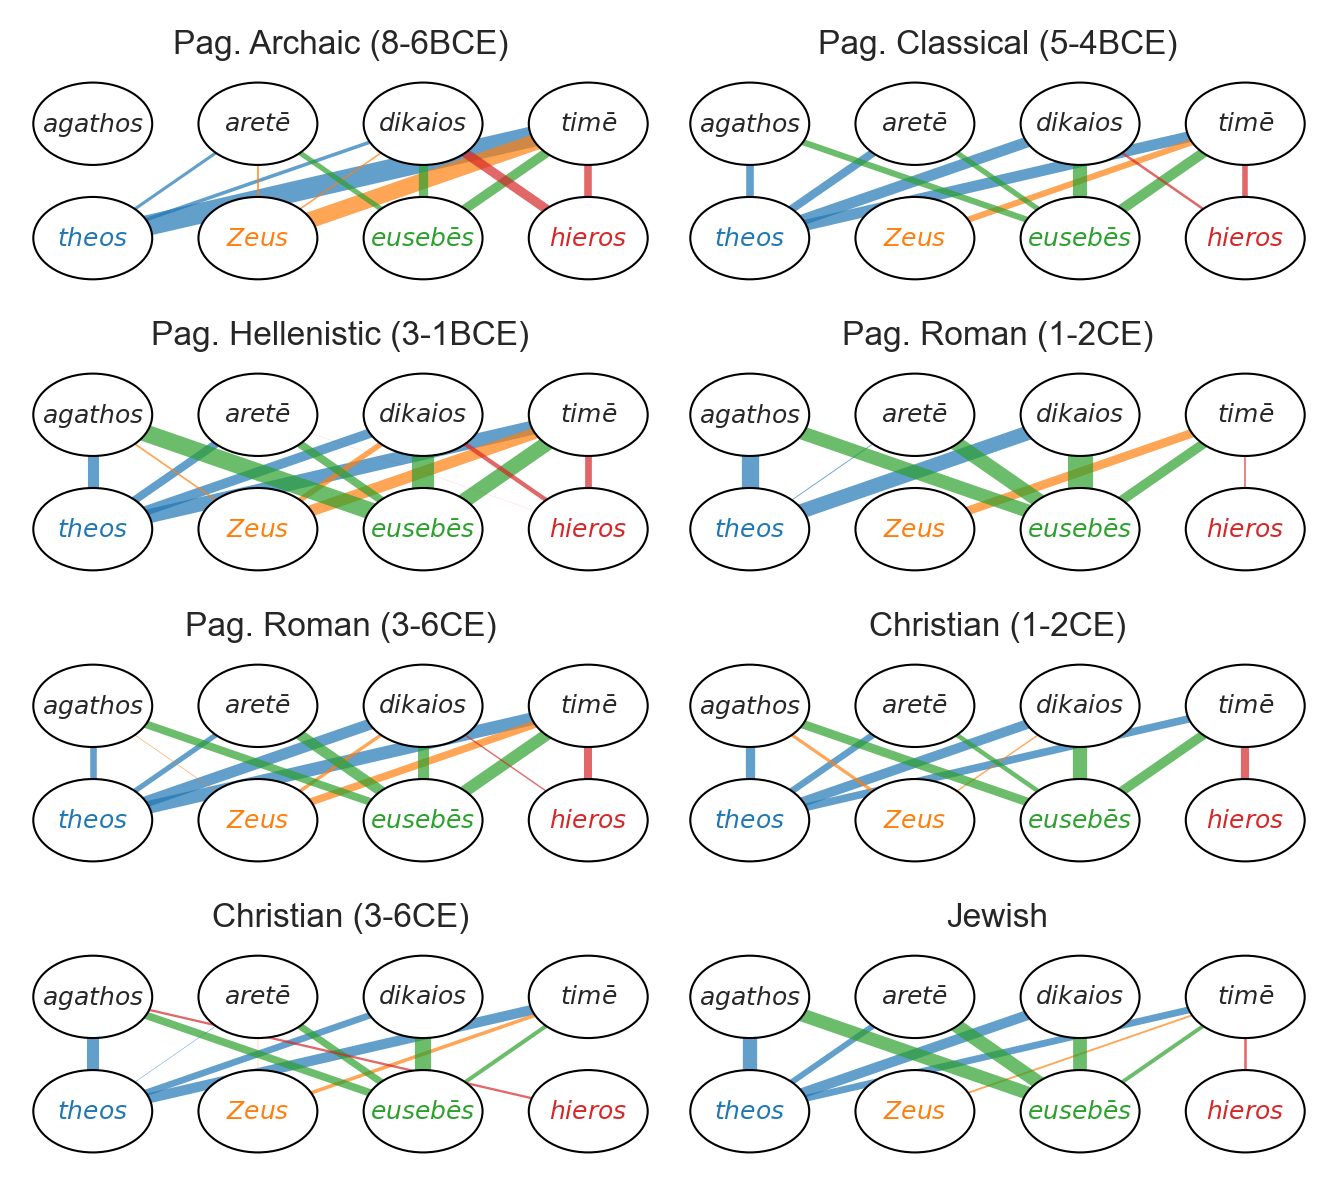

In [101]:
fig, axs = plt.subplots(4,2, figsize=(4.5, 4), tight_layout=True, dpi=300)
for sub, label, ax in zip(subcorpora_ordered, subcorpora_labels, axs.ravel()):
    plot_binet(sub, ax, width_coef=5, title=label)
axs[2,1].set_axis_off()

In [102]:
save_figure(fig, "binets_subcorpora")

# Detecting semantic change

In [75]:
def calculate_square_similarity_matrices(matrix_list):
    similarity_matrix_list = []

    for matrix in matrix_list:
        similarity_matrix = cosine_similarity(matrix, matrix)
        similarity_matrix_list.append(similarity_matrix)

    return similarity_matrix_list

In [76]:
vectors_matrices_list = [vectors_sample1m_dict[key].vectors for key in vectors_sample1m_dict.keys()]

In [77]:
vocabularies_list = [vectors_sample1m_dict[key].index_to_key for key in vectors_sample1m_dict.keys()]

In [78]:
similarity_matrix_list = calculate_square_similarity_matrices(vectors_matrices_list)

In [79]:
similarity_matrix_dfs = []
for vocab, matrix in zip(vocabularies_list, similarity_matrix_list):
    df = pd.DataFrame(matrix, columns=vocab, index=vocab)
    similarity_matrix_dfs.append(df)

In [80]:
# testing that we have the same values as above...
similarity_matrix_dfs[0].sort_values(religion_final[0], ascending=False)[religion_final[0]].head(11)

θεός        1.000000
Ζεύς        0.523597
ἀθάνατος    0.451420
Κρονίδης    0.420336
μάκαρ       0.409765
ἄλλος       0.408569
ἀγήραος     0.390853
νόος        0.375597
Ὀλύμπιος    0.374644
τιμή        0.371521
βροτός      0.359282
Name: θεός, dtype: float32

In [81]:
len(shared_vocabulary)

1220

In [82]:
df = pd.DataFrame({f'subset_{i}': similarity_matrix_dfs[i].loc[shared_vocabulary][morality_final[0]]
                   for i in range(len(similarity_matrix_dfs))})

In [83]:
df_corr = df.corr()
df_corr

,subset_0,subset_1,subset_2,subset_3,subset_4,subset_5,subset_6,subset_7
subset_0,1.000000,0.519471,0.476753,0.485669,0.483474,0.322570,0.371949,0.377439
subset_1,0.519471,1.000000,0.787643,0.821856,0.772135,0.533841,0.590037,0.566892
subset_2,0.476753,0.787643,1.000000,0.768155,0.717012,0.511860,0.579769,0.581669
subset_3,0.485669,0.821856,0.768155,1.000000,0.815182,0.559438,0.641341,0.647010
subset_4,0.483474,0.772135,0.717012,0.815182,1.000000,0.591308,0.651688,0.639354
subset_5,0.322570,0.533841,0.511860,0.559438,0.591308,1.000000,0.761769,0.578530
subset_6,0.371949,0.590037,0.579769,0.641341,0.651688,0.761769,1.000000,0.654679
subset_7,0.377439,0.566892,0.581669,0.647010,0.639354,0.578530,0.654679,1.000000


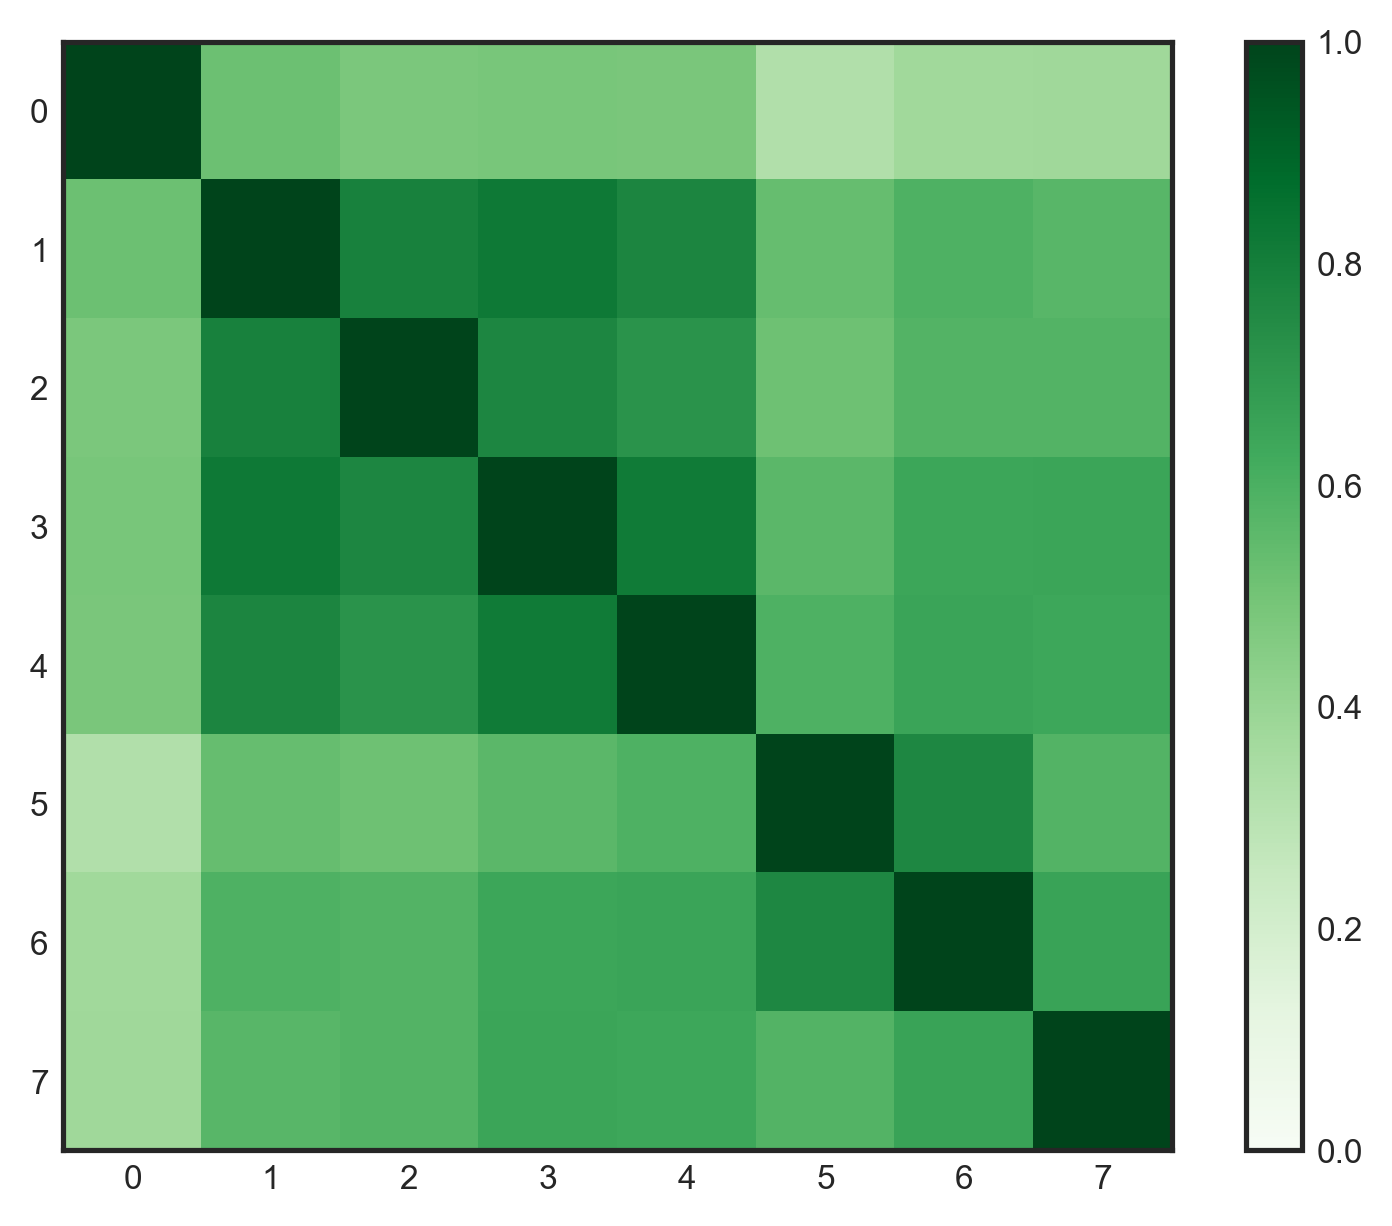

In [84]:
fig, ax = plt.subplots()
im = ax.imshow(df_corr, cmap='Greens', vmin=0, vmax=1)
cbar = fig.colorbar(im)

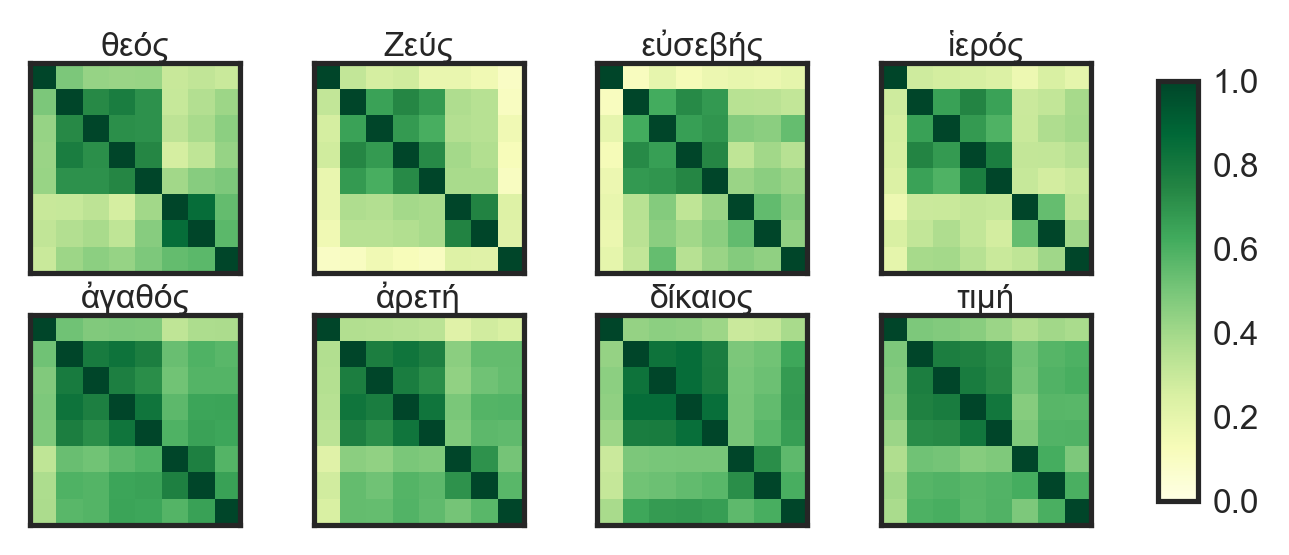

In [85]:
fig, axs = plt.subplots(2,4, figsize=(4.5, 2), dpi=300)

for i, (target, ax) in enumerate(zip(religion_final + morality_final, axs.flatten())):
    df = pd.DataFrame({f'subset_{i}': similarity_matrix_dfs[i].loc[shared_vocabulary][target]
                       for i in range(len(similarity_matrix_dfs))})

    df_corr = df.corr()
    im = ax.imshow(df_corr, cmap='YlGn', vmin=0, vmax=1)
    ax.set_title(target, fontsize=8, pad=-5)
    ax.set_xticks([])
    ax.set_yticks([])


# add a colorbar
fig.subplots_adjust(right=0.93)  # adjust the right boundary of the plot to make room for colorbar
cbar_ax = fig.add_axes([0.97, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

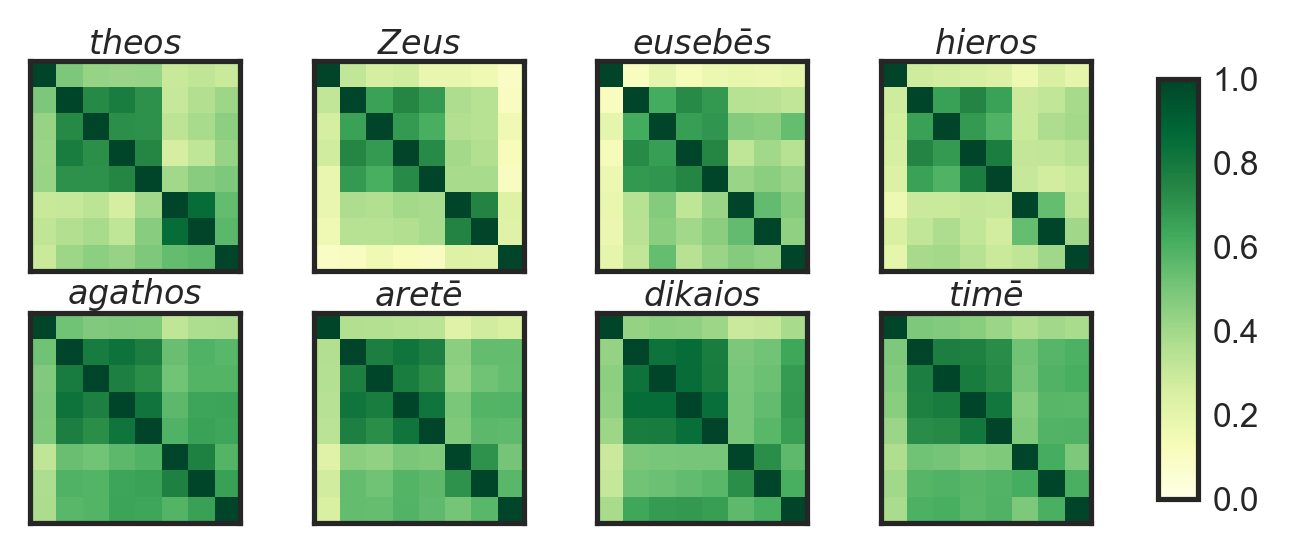

In [90]:
fig, axs = plt.subplots(2,4, figsize=(4.5, 2), dpi=300)

dfs_corrs = {}
for i, (target, ax) in enumerate(zip(religion_final + morality_final, axs.flatten())):
    df = pd.DataFrame({f'subset_{i}': similarity_matrix_dfs[i].loc[shared_vocabulary][target]
                       for i in range(len(similarity_matrix_dfs))})

    df_corr = df.corr()
    dfs_corrs[target] = df_corr
    im = ax.imshow(df_corr, cmap='YlGn', vmin=0, vmax=1)
    ax.set_title(f"$\it{{{transliterator(target)}}}$", fontsize=8, pad=-5)
    ax.set_xticks([])
    ax.set_yticks([])

# add a colorbar
fig.subplots_adjust(right=0.93)  # adjust the right boundary of the plot to make room for colorbar
cbar_ax = fig.add_axes([0.97, 0.15, 0.03, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [91]:
fig.savefig('../figures/semantic_change_correlations.png', dpi=300, bbox_inches='tight')
fig.savefig('../figures/semantic_change_correlations.tiff', dpi=300, bbox_inches='tight')


In [97]:
for key in dfs_corrs.keys():
    print(key, dfs_corrs[key].mean().mean())

θεός 0.5502161426327794
Ζεύς 0.44266492847638383
εὐσεβής 0.48614399626976124
ἱερός 0.46577846848645726
ἀγαθός 0.6502653377358281
ἀρετή 0.5896417976819186
δίκαιος 0.6355307520694667
τιμή 0.621929313022094


# Cosine similarities between wordpairs (outdated - with old subcorpora...)

In [112]:
for worda in religion_final:
    for wordb in morality_final:
        for sub in subcorpora:
            topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda, topn=100)])
            pair_sim_score = vectors_seed1_dict[sub].similarity(worda, wordb)
            print(sub, worda, wordb, pair_sim_score / topn_mean)

archaic θεός ἀγαθός 0.6859853730287353
classical θεός ἀγαθός 0.7937581052884033
roman θεός ἀγαθός 0.7145717591217652
christian θεός ἀγαθός 0.9617575234953456
jewish θεός ἀγαθός 1.1822418928459193
archaic θεός ἀρετή 0.41993004028630476
classical θεός ἀρετή 0.8450263395365437
roman θεός ἀρετή 0.5492563632648265
christian θεός ἀρετή 0.27518312516259785
jewish θεός ἀρετή 0.31779802519383465
archaic θεός δίκαιος 0.22834231093313714
classical θεός δίκαιος 0.8226298370453234
roman θεός δίκαιος 0.7867665440452801
christian θεός δίκαιος 1.0397812514037141
jewish θεός δίκαιος 1.225755574019601
archaic θεός τιμή 1.2886583605718605
classical θεός τιμή 0.860080095564542
roman θεός τιμή 0.8949358909023666
christian θεός τιμή 0.29679031845601
jewish θεός τιμή 0.17466140942703942
archaic Ζεύς ἀγαθός 0.9979027742612252
classical Ζεύς ἀγαθός -0.22520881442190036
roman Ζεύς ἀγαθός 0.09653659255043805
christian Ζεύς ἀγαθός 0.3133041048181849
jewish Ζεύς ἀγαθός -0.3756920452029299
archaic Ζεύς ἀρετή 0.5529

# Cosine similarity - bar plots - word groups

In [113]:
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

In [114]:
vectors_seed1_dict[sub].n_similarity(religion_final, morality_final)

0.30416095

In [115]:
sub = "classical"
vectors_seed1_dict[sub].most_similar(religion_final, topn=10)

[('τελετή', 0.5350894927978516),
 ('βωμός', 0.5333253741264343),
 ('Ἀπόλλων', 0.5327228903770447),
 ('Ἀθήνη', 0.5257604718208313),
 ('ἁγνός', 0.5190330743789673),
 ('Ὀλύμπιος', 0.5088062882423401),
 ('δαίμων', 0.5083577036857605),
 ('Ἀσκληπιός', 0.5019826889038086),
 ('ὅσιος', 0.5013136267662048),
 ('θῦμα', 0.49985650181770325)]

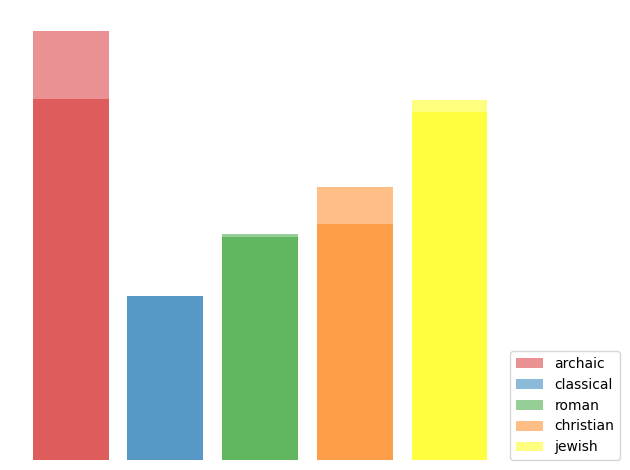

In [118]:
### religion vs morality

fig, ax = plt.subplots(tight_layout=True)
scores = []
for sub in subcorpora:
    score = vectors_seed1_dict[sub].n_similarity(religion_final, morality_final)
    topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(religion_final, topn=20)])
    score = score / topn_mean
    scores.append(score)
ax.bar(subcorpora, scores, alpha=0.5, label=bar_labels, color=bar_colors)

scores = []
for sub in subcorpora:
    score = vectors_seed2_dict[sub].n_similarity(religion_final, morality_final)
    topn_mean = np.mean([tup[1] for tup in vectors_seed2_dict[sub].most_similar(religion_final, topn=20)])
    score = score / topn_mean
    scores.append(score)
ax.bar(subcorpora, scores, alpha=0.5, color=bar_colors)

ax.legend(loc=(1,0))
ax.set_axis_off()

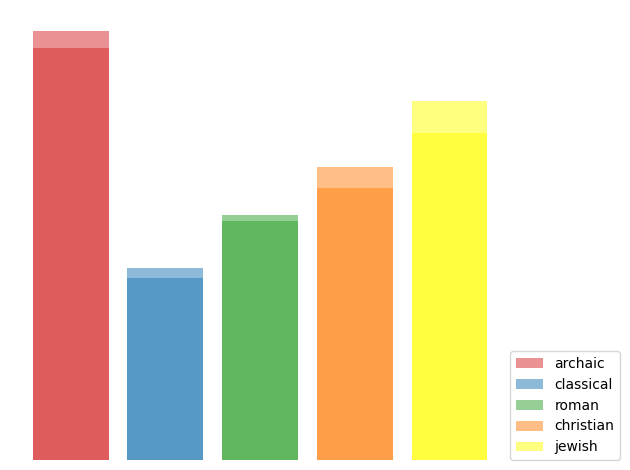

In [119]:
# religion x morality (extended)

fig, ax = plt.subplots(tight_layout=True)
scores = []
for sub in subcorpora:
    score = vectors_seed1_dict[sub].n_similarity(religion_final, morality_final + morality_extension)
    topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(religion_final, topn=20)])
    score = score / topn_mean
    scores.append(score)
ax.bar(subcorpora, scores, alpha=0.5, label=bar_labels, color=bar_colors)

scores = []
for sub in subcorpora:
    score = vectors_seed2_dict[sub].n_similarity(religion_final, morality_final + morality_extension)
    topn_mean = np.mean([tup[1] for tup in vectors_seed2_dict[sub].most_similar(religion_final, topn=20)])
    score = score / topn_mean
    scores.append(score)
ax.bar(subcorpora, scores, alpha=0.5, color=bar_colors)

ax.legend(loc=(1,0))
ax.set_axis_off()

In [120]:
worda = religion_final[0]

In [121]:
sub = "archaic"
counted_indiv = []
for mor in morality_final:
    counted_indiv.append(vectors_seed2_dict[sub].similarity(worda, mor))

In [122]:
np.mean(counted_indiv)

0.16752025

In [123]:
topn_mean = np.mean([tup[1] for tup in vectors_seed2_dict[sub].most_similar(worda, topn=10)])
topn_mean

0.35297555327415464

In [124]:
np.mean(counted_indiv) / topn_mean

0.47459449612442506

In [125]:
vectors_seed2_dict["archaic"].most_similar(worda)

[('Ζεύς', 0.48166871070861816),
 ('εἰμί', 0.3897678852081299),
 ('κακός', 0.3576022684574127),
 ('ἀθάνατος', 0.3502071797847748),
 ('φίλος', 0.3405264914035797),
 ('πᾶς', 0.33348512649536133),
 ('Κρονίδης', 0.3287004232406616),
 ('ξένος', 0.32598140835762024),
 ('τελευτάω', 0.3150055706501007),
 ('τιμή', 0.3068104684352875)]

In [126]:
for mor in morality_final:
    print(vectors_seed1_dict["classical"].similarity(religion_final[0], mor))

0.24795187
0.2639669
0.25697073
0.26866934


/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_37832/390095021.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,0].set_xticklabels(subcorpora, rotation=90)
/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_37832/390095021.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1,1].set_xticklabels(subcorpora, rotation=90)


[Text(0, 0, 'archaic'),
 Text(1, 0, 'classical'),
 Text(2, 0, 'roman'),
 Text(3, 0, 'christian'),
 Text(4, 0, 'jewish')]

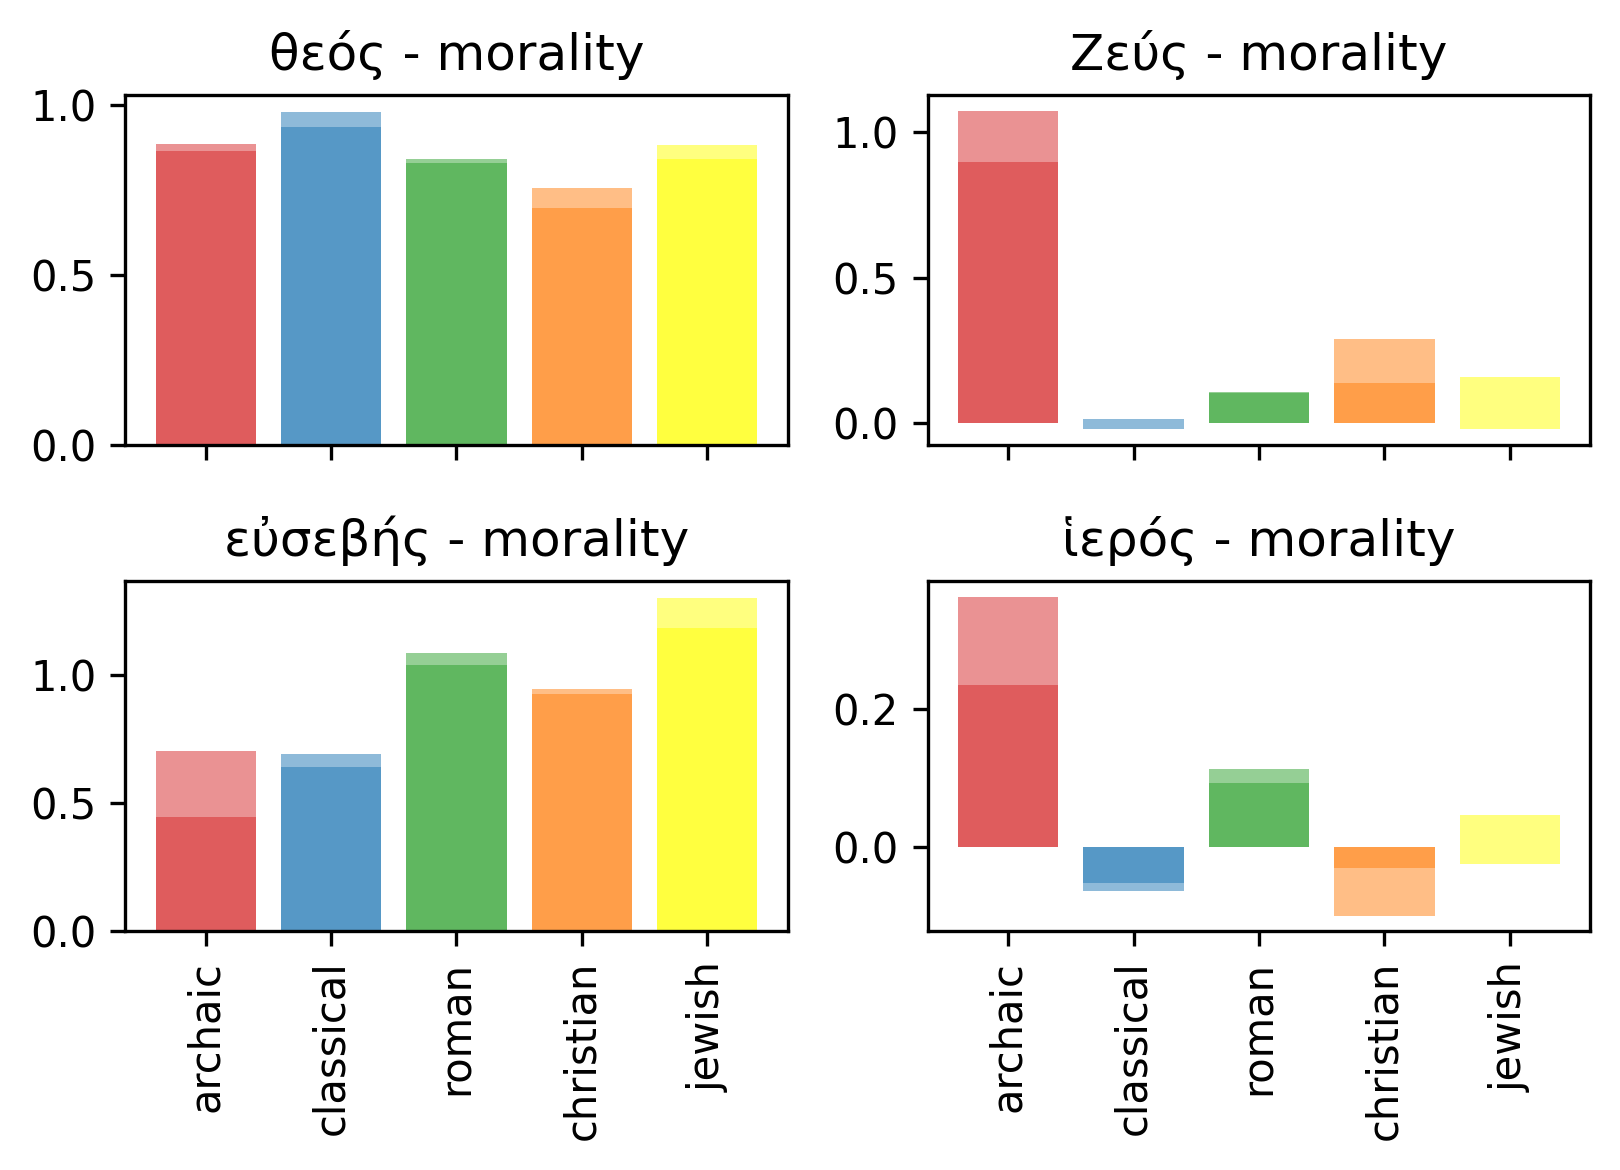

In [127]:
fig, axs = plt.subplots(2, 2, figsize=(5.5,4), dpi=300, tight_layout=True)
for worda, ax in zip(religion_final, axs.ravel()):
    scores = []
    for sub in subcorpora:
        score = vectors_seed1_dict[sub].n_similarity([worda], morality_final)
        topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda, topn=20)])
        score = score / topn_mean
        scores.append(score)
    ax.bar(subcorpora, scores, alpha=0.5, label=subcorpora, color=bar_colors)
    scores = []
    for sub in subcorpora:
        score = vectors_seed2_dict[sub].n_similarity([worda], morality_final)
        topn_mean = np.mean([tup[1] for tup in vectors_seed2_dict[sub].most_similar(worda, topn=20)])
        score = score / topn_mean
        scores.append(score)
    ax.bar(subcorpora, scores, alpha=0.5, label=subcorpora, color=bar_colors)
    ax.set_title(worda + " - morality")

axs[0,0].set_xticklabels([])
axs[0,1].set_xticklabels([])

axs[1,0].set_xticklabels(subcorpora, rotation=90)
axs[1,1].set_xticklabels(subcorpora, rotation=90)


In [128]:
fig.savefig("../figures/subcorpora_bars_relindividal_vs_morality.png")

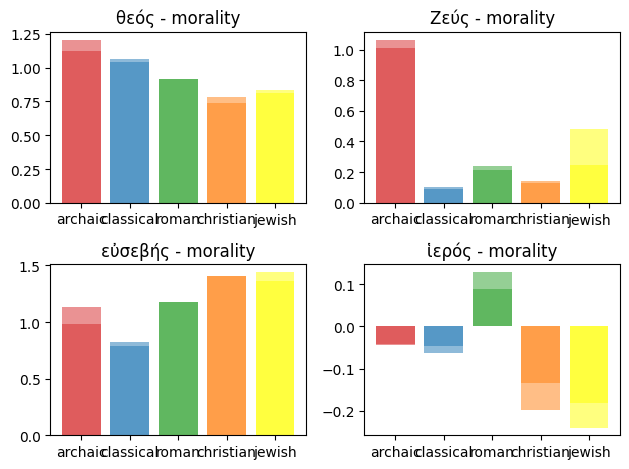

In [129]:
fig, axs = plt.subplots(2, 2, tight_layout=True)
for worda, ax in zip(religion_final, axs.ravel()):
    scores = []
    for sub in subcorpora:
        score = vectors_seed1_dict[sub].n_similarity([worda], morality_final + morality_extension)
        topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda, topn=20)])
        score = score / topn_mean
        scores.append(score)
    ax.bar(subcorpora, scores, alpha=0.5, label=subcorpora, color=bar_colors)
    ax.set_title(worda + " - morality")
    scores = []
    for sub in subcorpora:
        score = vectors_seed2_dict[sub].n_similarity([worda], morality_final + morality_extension)
        topn_mean = np.mean([tup[1] for tup in vectors_seed2_dict[sub].most_similar(worda, topn=20)])
        score = score / topn_mean
        scores.append(score)
    ax.bar(subcorpora, scores, alpha=0.5, label=subcorpora, color=bar_colors)
    ax.set_title(worda + " - morality")

# Cosine similarity - bar plots - individual words

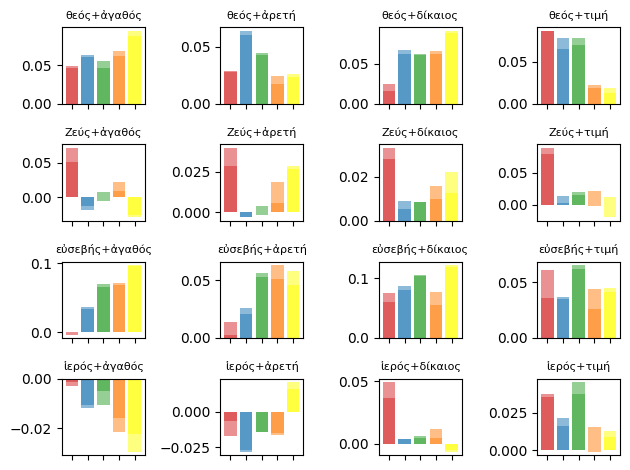

In [130]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            #topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda, topn=10)])
            #pair_sim_score = vectors_seed1_dict[sub].similarity(worda[1], wordb[1])
            #score = pair_sim_score / topn_mean
            score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            score = vectors_seed2_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])

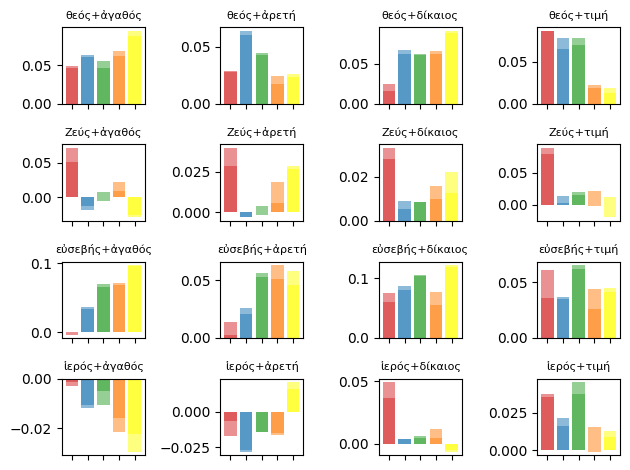

In [131]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            #topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda, topn=10)])
            #pair_sim_score = vectors_seed1_dict[sub].similarity(worda[1], wordb[1])
            #score = pair_sim_score / topn_mean
            score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            score = vectors_seed2_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])

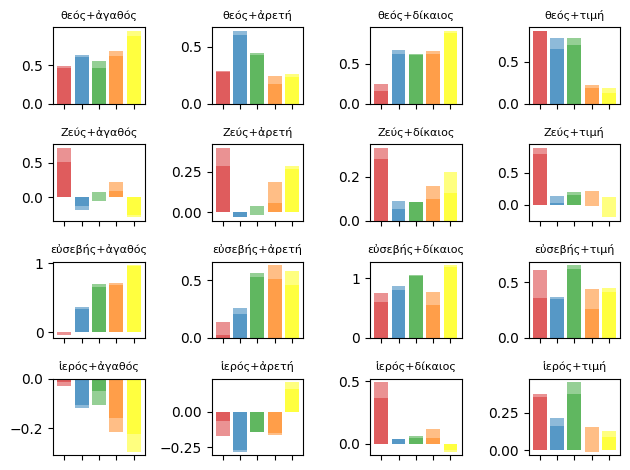

In [132]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda[1], topn=10)])
            pair_sim_score = vectors_seed1_dict[sub].similarity(worda[1], wordb[1])
            score = pair_sim_score / topn_mean
            #score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            topn_mean = np.mean([tup[1] for tup in vectors_seed2_dict[sub].most_similar(worda[1], topn=10)])
            pair_sim_score = vectors_seed2_dict[sub].similarity(worda[1], wordb[1])
            #score = vectors_seed2_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            score = pair_sim_score / topn_mean
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])

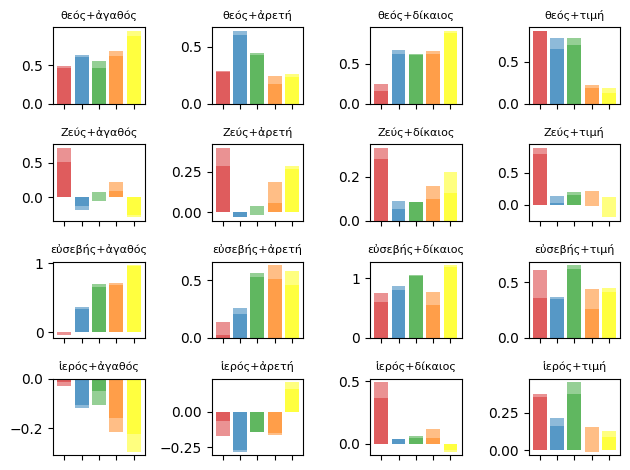

In [133]:
fig, axs = plt.subplots(4,4, tight_layout=True)
bar_labels = subcorpora
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'yellow']

for worda in enumerate(religion_final):
    for wordb in enumerate(morality_final):
        sub_pair_data_seed1 = []
        sub_pair_data_seed2 = []
        for sub in subcorpora:
            topn_mean = np.mean([tup[1] for tup in vectors_seed1_dict[sub].most_similar(worda[1], topn=10)])
            pair_sim_score = vectors_seed1_dict[sub].similarity(worda[1], wordb[1])
            score = pair_sim_score / topn_mean
            #score = vectors_seed1_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            sub_pair_data_seed1.append(score)
            topn_mean = np.mean([tup[1] for tup in vectors_seed2_dict[sub].most_similar(worda[1], topn=10)])
            pair_sim_score = vectors_seed2_dict[sub].similarity(worda[1], wordb[1])
            #score = vectors_seed2_dict[sub].relative_cosine_similarity(worda[1], wordb[1])
            score = pair_sim_score / topn_mean
            sub_pair_data_seed2.append(score)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed1, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].bar(subcorpora, sub_pair_data_seed2, alpha=0.5, label=bar_labels, color=bar_colors)
        axs[worda[0], wordb[0]].set_title(worda[1] + "+" + wordb[1], fontsize=8)
        axs[worda[0], wordb[0]].set_xticklabels([])

# Cosine similarity - Bimodal networks

In [134]:
coords = []
for n_lower in range(4):
    for n_upper in range(4):
        xs, ys = [n_lower, n_upper], [0,1]
        coords.append((xs, ys))
color_dict = {
    "θεός" : "tab:blue",
    "Ζεύς" : "tab:orange",
    "εὐσεβής" : "tab:green",
    "ἱερός" : "tab:red",
}

Text(0.5, 1.0, 'classical')

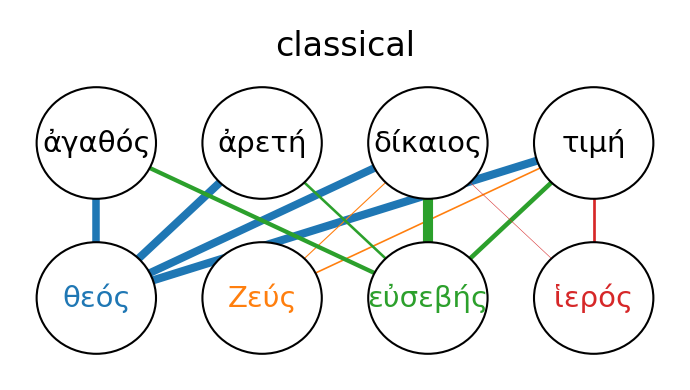

In [135]:
sub = "classical"

sim_pairs = []
for worda in religion_final:
    for wordb in morality_final:
        sim_pairs.append((worda, wordb, vectors_seed1_dict[sub].relative_cosine_similarity(worda, wordb)))

width_coef = 30
fig, ax = plt.subplots(figsize=(2.4, 1.4), tight_layout=True, dpi=300)

for n, word in enumerate(religion_final):
    ax.text(x=n, y=0, s=word, fontsize=7, color=color_dict[word], horizontalalignment='center', verticalalignment='center')
    circle = patches.Circle(xy=(n, 0), radius=0.36, facecolor="white", linewidth=0.5, edgecolor="black", zorder=2)
    ax.add_patch(circle)
for n, word in enumerate(morality_final):
    ax.text(x=n, y=1, s=word, fontsize=7, horizontalalignment='center', verticalalignment='center')
    circle = patches.Circle(xy=(n, 1), radius=0.36, facecolor="white", linewidth=0.5, edgecolor="black", zorder=2)
    ax.add_patch(circle)


for tup, coord in zip(sim_pairs, coords):
    if tup[2] > 0:
        ax.plot(coord[0], coord[1], linewidth=tup[2]*width_coef, color=color_dict[tup[0]], zorder=1)

ax.set_xlim(-0.4,3.4)
ax.set_ylim(-0.4, 1.4)
ax.axis(False)
ax.set_title(sub, fontsize=8)

In [136]:
def plot_binet(sub, ax=ax):
    sim_pairs = []
    for worda in religion_final:
        for wordb in morality_final:
            sim_pairs.append((worda, wordb, vectors_seed1_dict[sub].relative_cosine_similarity(worda, wordb)))
    width_coef = 30
    for n, word in enumerate(religion_final):
        ax.text(x=n, y=0, s=word, fontsize=6, color=color_dict[word], horizontalalignment='center', verticalalignment='center')
        circle = patches.Circle(xy=(n, 0), radius=0.36, facecolor="white", linewidth=0.5, edgecolor="black", zorder=2)
        ax.add_patch(circle)
    for n, word in enumerate(morality_final):
        ax.text(x=n, y=1, s=word, fontsize=6, horizontalalignment='center', verticalalignment='center')
        circle = patches.Circle(xy=(n, 1), radius=0.36, facecolor="white", linewidth=0.5, edgecolor="black", zorder=2)
        ax.add_patch(circle)
    for tup, coord in zip(sim_pairs, coords):
        if tup[2] > 0:
            ax.plot(coord[0], coord[1], linewidth=tup[2]*width_coef, color=color_dict[tup[0]], zorder=1)
    ax.set_xlim(-0.38,3.38)
    ax.set_ylim(-0.4, 1.4)
    ax.axis(False)
    ax.set_title(sub, fontsize=8)
    return ax

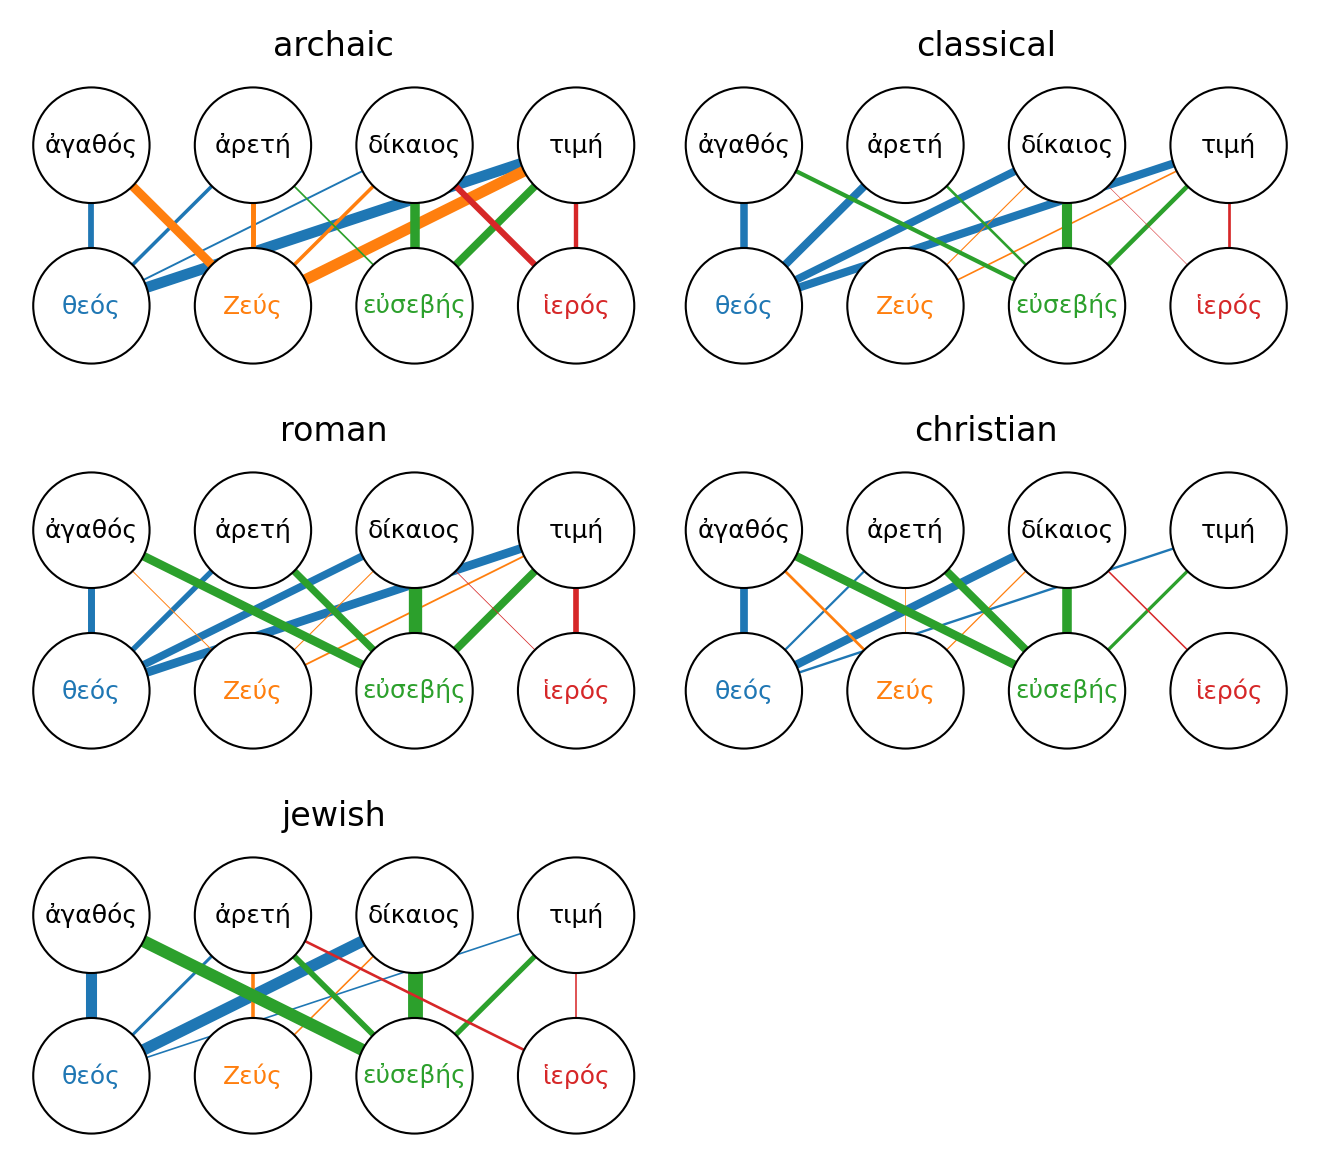

In [137]:
fig, axs = plt.subplots(3,2, figsize=(4.5, 4), tight_layout=True, dpi=300)
for sub, ax in zip(subcorpora, axs.ravel()):
    plot_binet(sub, ax)
axs[2,1].set_axis_off()

In [138]:
fig.savefig("../figures/bimodal_networks.png")

# Embeddings plot

In [139]:
sub = "christian"
keyed_vectors = vectors_seed1_dict[sub]
vectors = keyed_vectors.vectors
words = keyed_vectors.index_to_key

In [140]:
keys=religion_final

In [141]:
keyed_vectors[religion_final]

array([[ 0.20839396,  0.58236957, -0.01062707, -0.43040055, -0.19236174,
        -0.23785703,  0.37911752, -0.29966933,  0.2970522 , -0.4007235 ,
         0.05536499, -0.5416803 ,  0.05724937,  0.01540111,  0.8356218 ,
        -0.2443895 , -0.0149554 , -0.00441786, -0.60239637, -0.08805191,
         0.2185401 , -0.22600168, -0.31671563,  0.4413568 , -0.28602436,
        -0.2206001 ,  0.58276206,  0.5896599 ,  1.1196811 ,  0.6146839 ,
        -0.08168429, -0.26607892,  0.46251523,  0.00500035,  0.08103323,
        -0.19691193, -0.5445623 , -0.19056506, -0.5194927 ,  0.650357  ,
         0.02743253, -0.09882445,  0.90376383,  0.01130894,  0.46151954,
         0.3431653 ,  0.14193135, -0.25923228, -0.3153593 , -0.65246075,
         0.7007912 , -0.14518954, -0.01514992, -0.01053757, -0.16507365,
         0.00864254,  0.18457696,  0.15926962, -0.13448222, -0.49051675,
         0.3897148 ,  0.71386415,  0.16992812,  0.18080813, -0.26918823,
        -0.0820419 ,  0.40219513,  1.0437195 ,  0.6

In [142]:
def get_tsne_coors(keyed_vectors, keys=None, perplexity=18, seed=1):
    if keys != None:
        vectors = keyed_vectors[keys]
        words = np.array(keys)
    else:
        vectors = keyed_vectors.vectors
        words = np.array(keyed_vectors.index_to_key)
    tsne = TSNE(n_components=2, random_state=seed, perplexity=perplexity, init="pca", learning_rate='auto', metric='cosine', n_iter=1000) # dissimilarity="precomputed",
    pos = tsne.fit_transform(vectors) # project all points into space
    xs, ys = pos[:, 0], pos[:, 1]
    minmax = [pos[:, 0].min(), pos[:, 0].max(), pos[:, 1].min(), pos[:, 1].max()]
    # normalize on scale from 0 to 1
    xs = (xs - minmax[0]) / (minmax[1] - minmax[0])
    ys = (ys - minmax[2]) / (minmax[3] - minmax[2])
    return xs, ys, words

In [143]:
xs, ys, words = get_tsne_coors(keyed_vectors, keys=None, perplexity=30)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [156]:
def draw_special_words(wordlist, color, xs, ys, words, ax=ax, fontsize=6):
    color_idx = [word[0] for word in enumerate(words) if word[1] in wordlist]
    for x,y,w in zip(xs[color_idx], ys[color_idx] - 0.003, words[color_idx]):
        ax.text(x,y,w, horizontalalignment='center', fontsize=fontsize, color=color, zorder=3)

def plot_embeddings(sub, ax=ax):
    keyed_vectors = vectors_seed1_dict[sub]
    xs, ys, words = get_tsne_coors(keyed_vectors, keys=None, perplexity=5)
    special_words = religion_final + morality_final + morality_extension
    # all words as dots if not in lists
    dots_idx = [word[0] for word in enumerate(words) if word[1] not in special_words]
    ax.scatter(xs[dots_idx], ys[dots_idx], s=1, color="lightgrey", zorder=1)
    draw_special_words(religion_final, "green",  xs, ys, words, ax=ax)
    draw_special_words(morality_final, "red",  xs, ys, words, ax=ax)
    draw_special_words(morality_extension, "orange",  xs, ys, words, ax=ax)
    draw_special_words(religion_extension, "lightgreen",  xs, ys, words, ax=ax)
    #ax.axes.get_xaxis().set_visible(False)
    #ax.axes.get_yaxis().set_visible(False)
    ax.set_axis_off()
    fig.savefig("../figures/embeddings_{}.png".format(sub))
    return ax

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


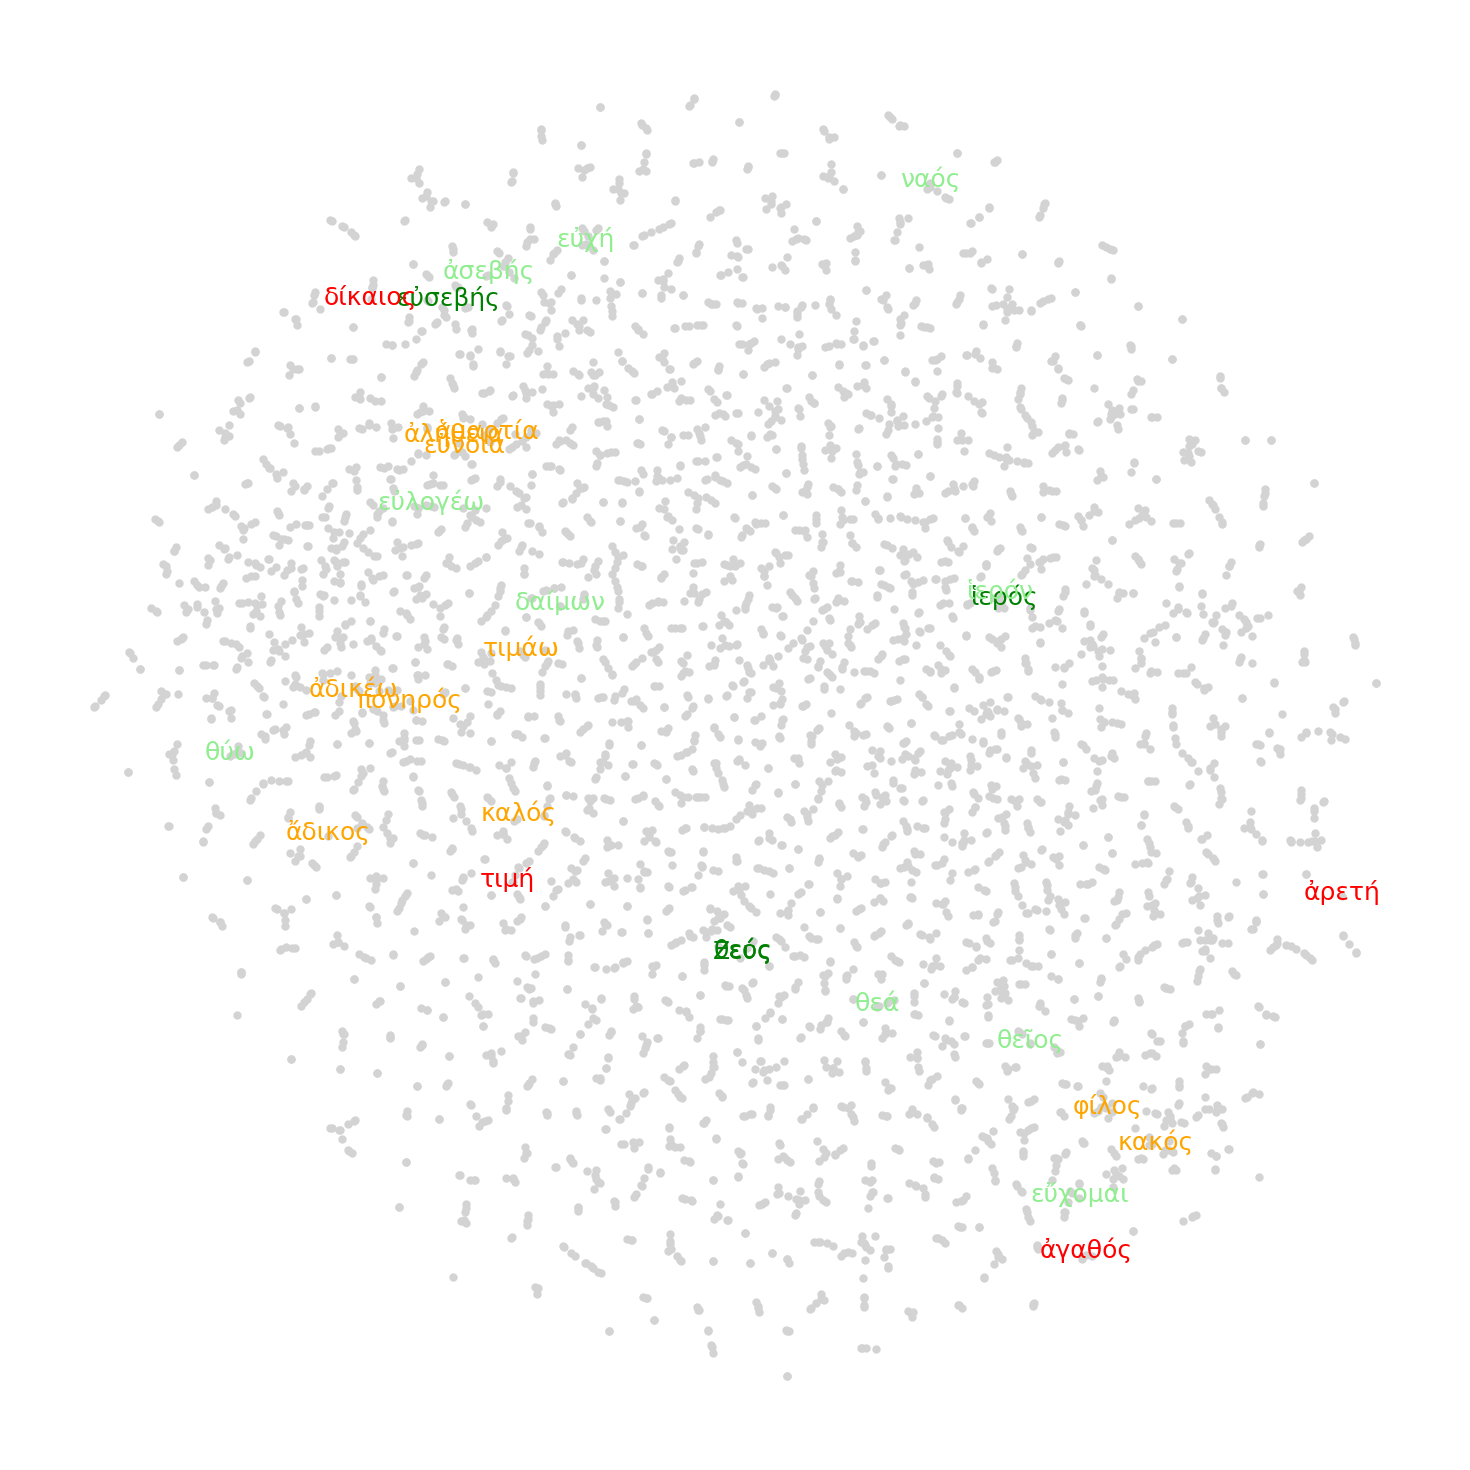

In [147]:
sub = "archaic"
fig, ax = plt.subplots(figsize=(5, 5), dpi=300, tight_layout=True)
plot_embeddings(sub, ax=ax)
ax.set_axis_off()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


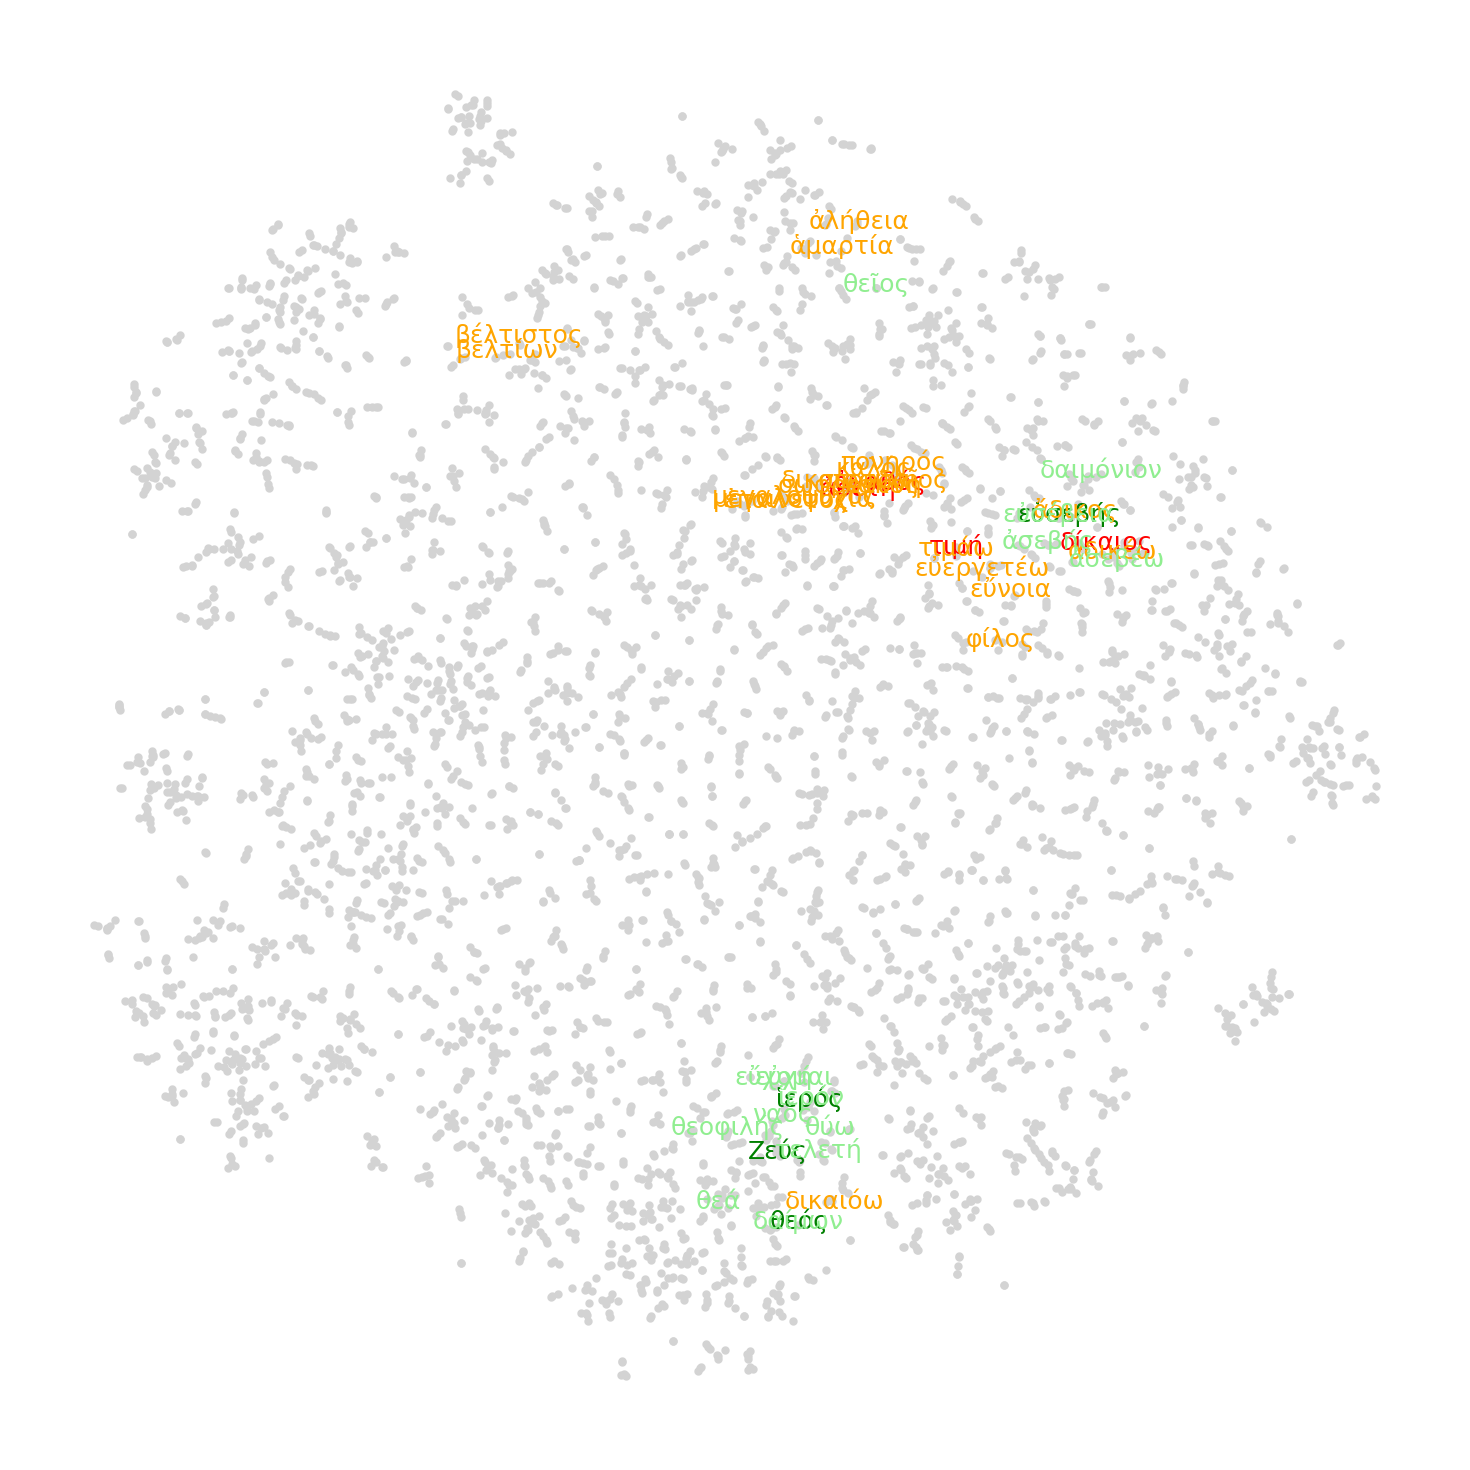

In [157]:
sub = "classical"
fig, ax = plt.subplots(figsize=(5, 5), dpi=300, tight_layout=True)
plot_embeddings(sub, ax=ax)
ax.set_axis_off()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


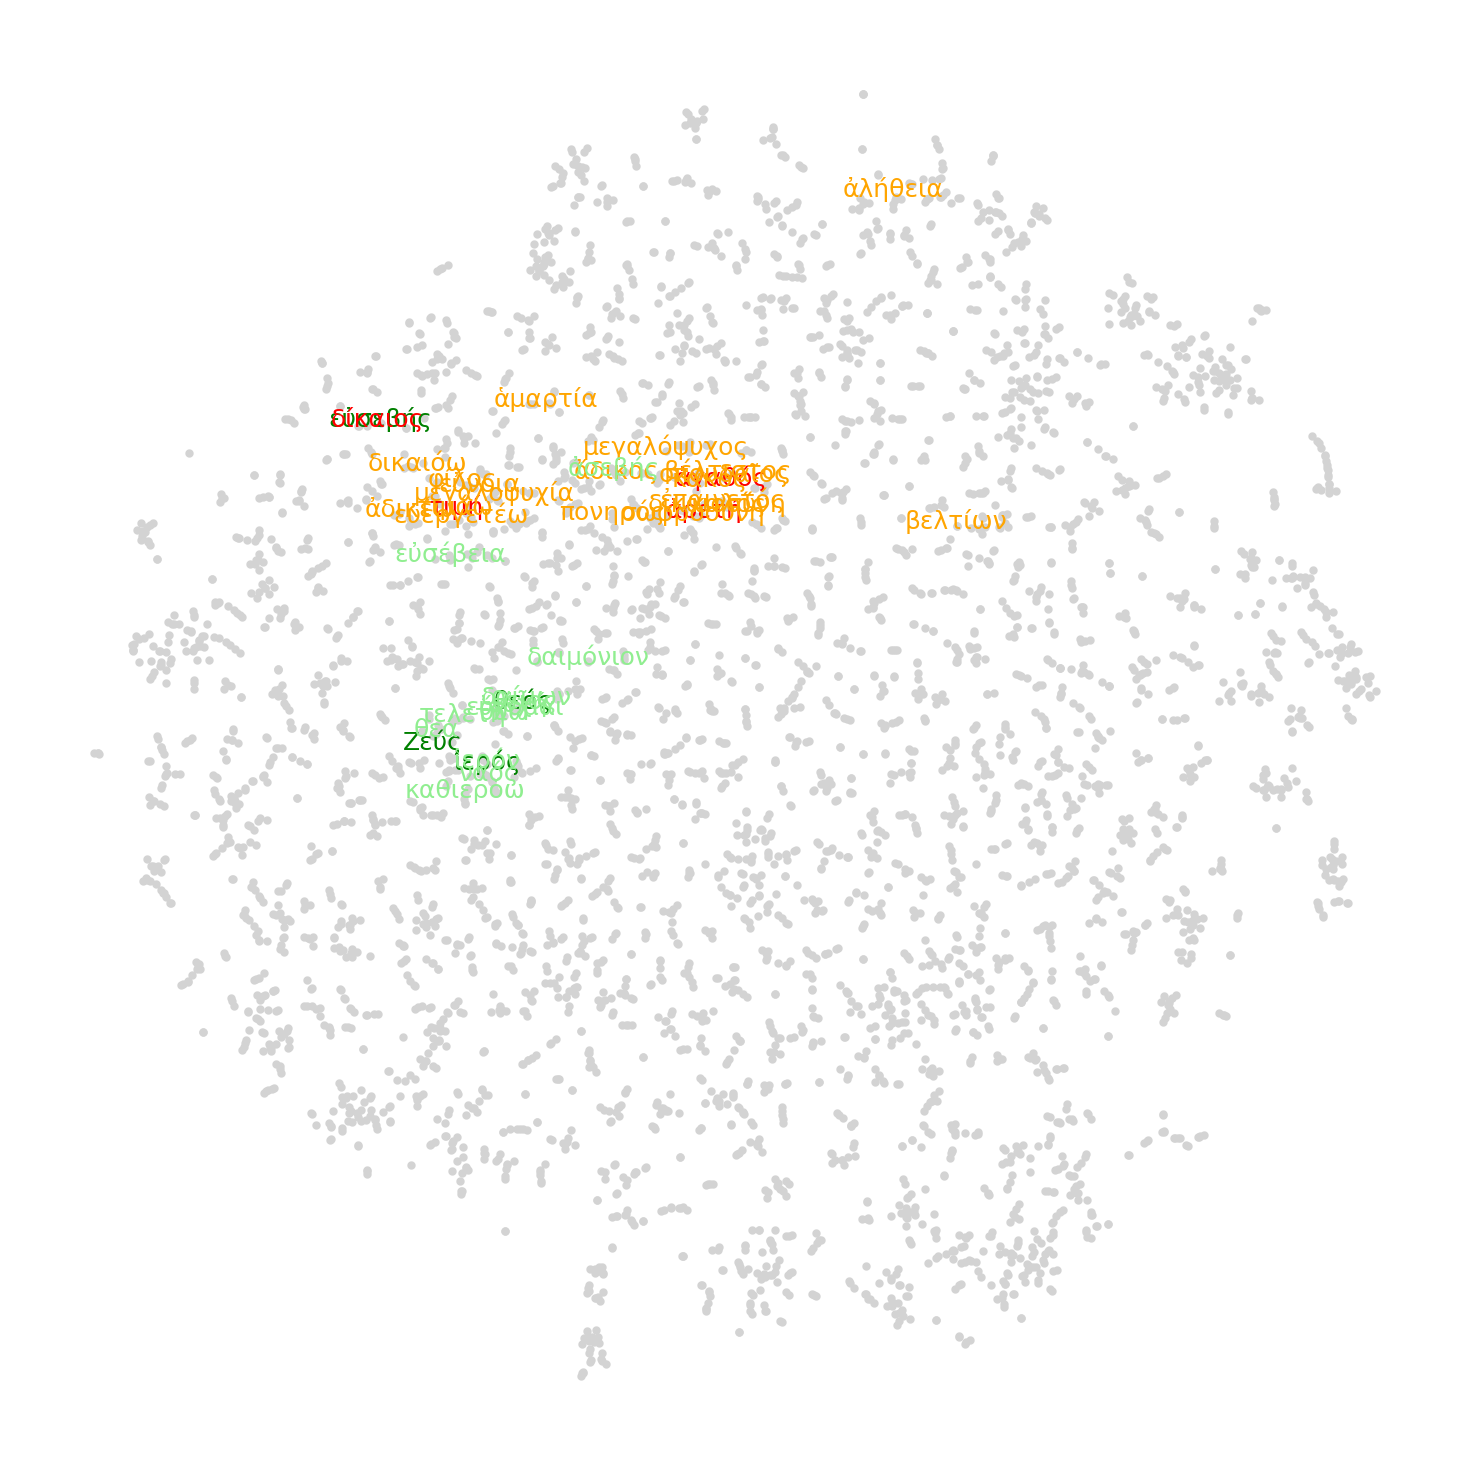

In [158]:
sub = "roman"
fig, ax = plt.subplots(figsize=(5, 5), dpi=300, tight_layout=True)
plot_embeddings(sub, ax=ax)
ax.set_axis_off()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


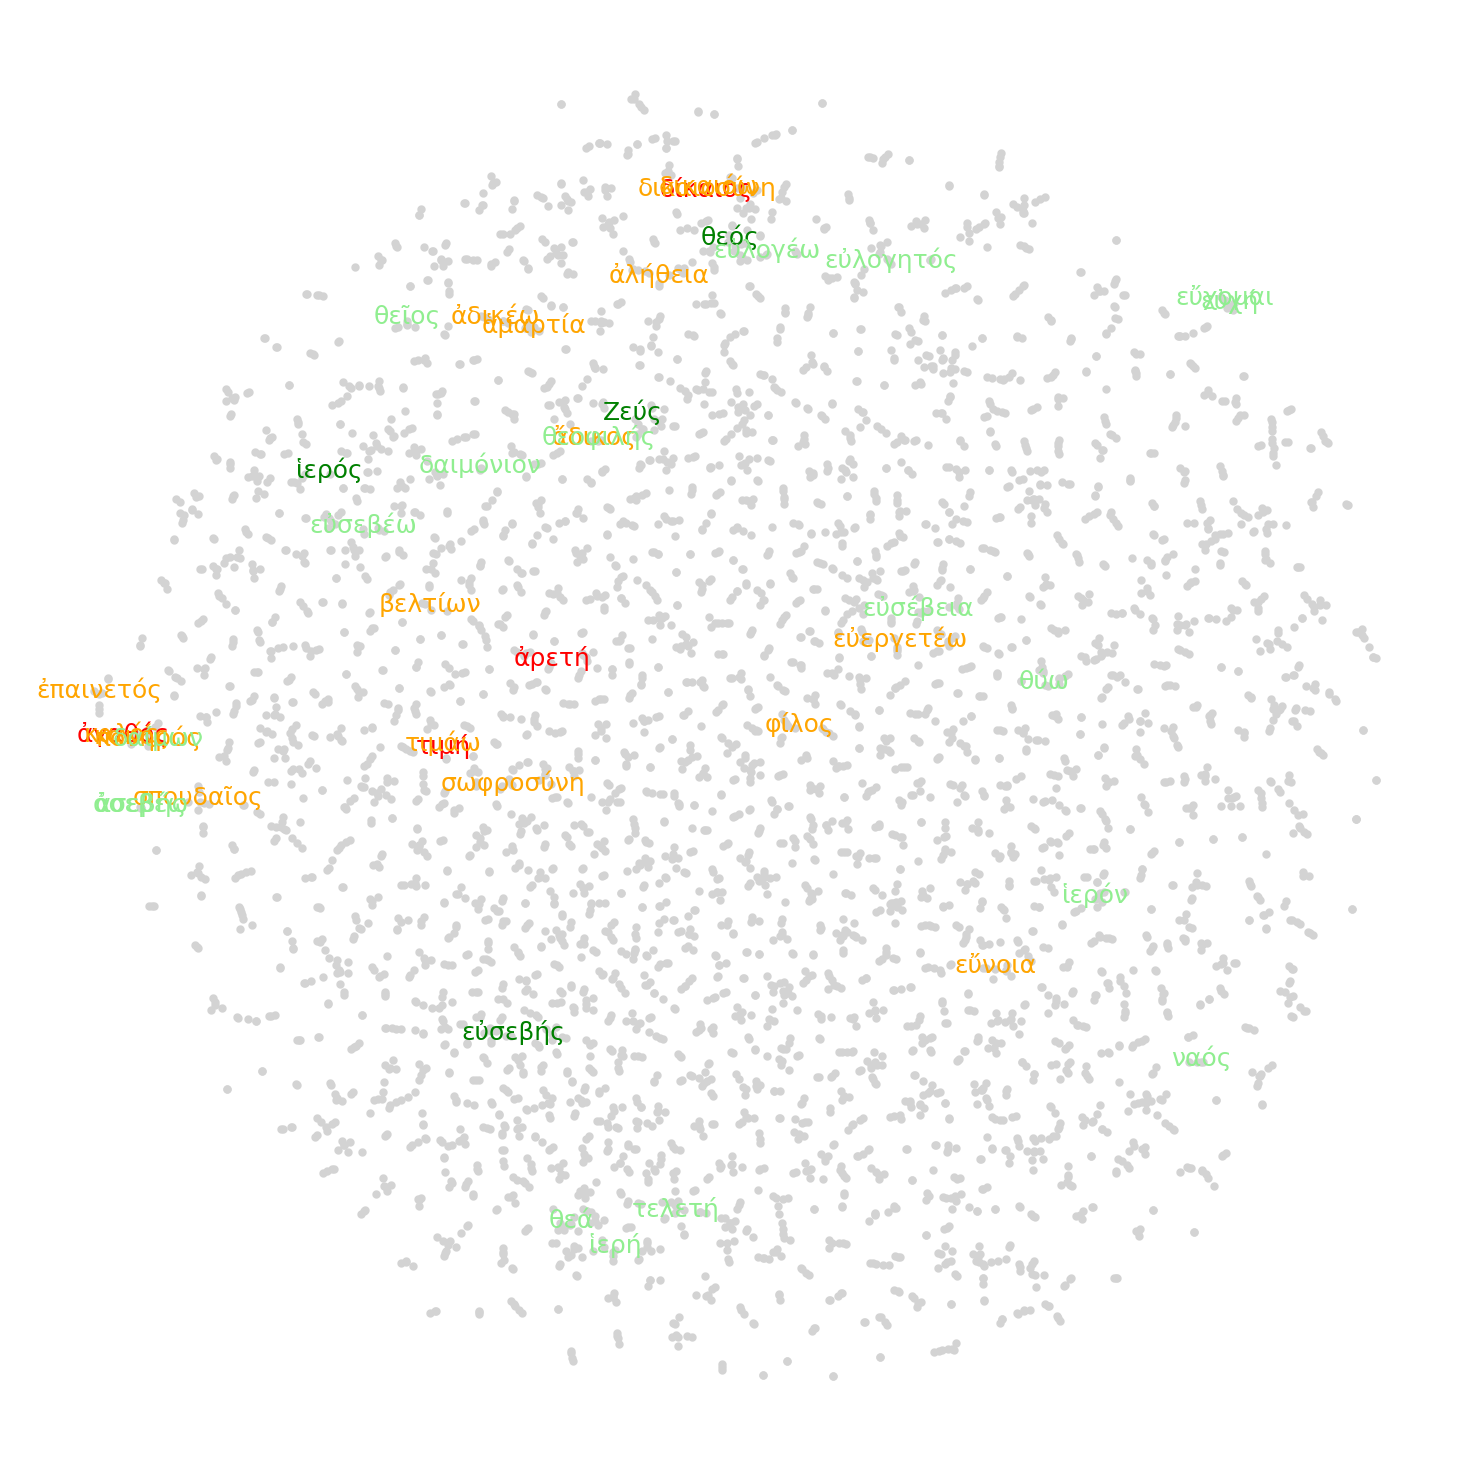

In [159]:
sub = "christian"
fig, ax = plt.subplots(figsize=(5, 5), dpi=300, tight_layout=True)
plot_embeddings(sub, ax=ax)
ax.set_axis_off()

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


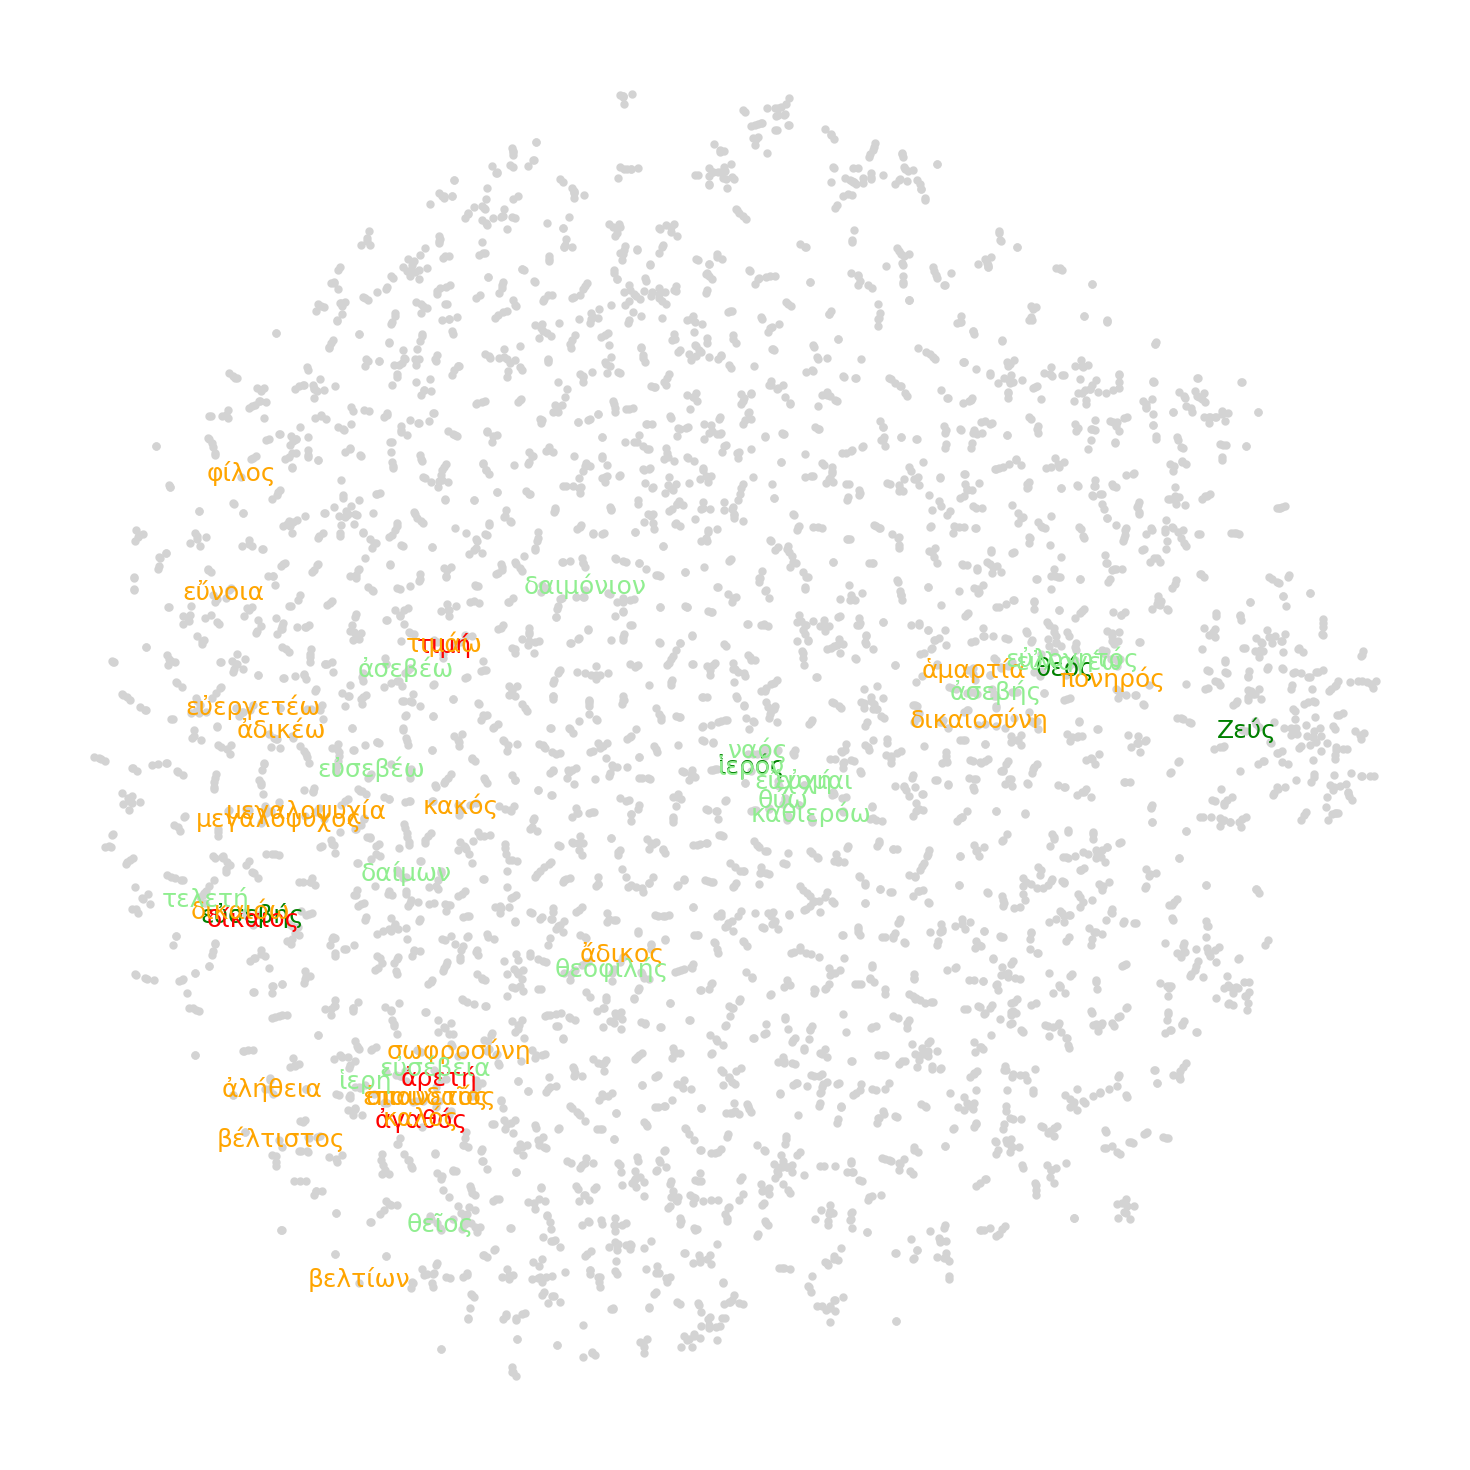

In [160]:
sub = "jewish"
fig, ax = plt.subplots(figsize=(5, 5), dpi=300, tight_layout=True)
plot_embeddings(sub, ax=ax)
ax.set_axis_off()